In [90]:
# Initialize Notebook
from IPython.core.display import HTML
#%run ../library/v1.0.5/init.ipy
HTML('''<script> code_show=true;  function code_toggle() {  if (code_show){  $('div.input').hide();  } else {  $('div.input').show();  }  code_show = !code_show }  $( document ).ready(code_toggle); </script> <form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [91]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[1])
sns.set_style(styles[0])
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
cd /home/chenxupeng/projects/exseek

/home/chenxupeng/projects/exseek


# Statistics

## file path

In [92]:
file_counts = 'output/scirep/summary/read_counts.txt'
file_length_path = 'output/scirep/stats/mapped_read_length_by_sample/'
plot_save_path = 'output/scirep/plots/'
sequencing_type = 'short'

## Get table

In [4]:
def get_counts_ratio_table(file_counts):
    df = pd.read_table(file_counts, index_col=0)
    rna_types = [s.split('.')[0] for s in df.index.tolist() if s.endswith('.mapped')]
    rna_types = 'rRNA,miRNA,piRNA,Y_RNA,srpRNA,tRNA,snRNA,snoRNA,lncRNA,mRNA,tucpRNA,intron,promoter,enhancer,repeats,circRNA,other'.split(',')
    mapped_ratio = {}
    mapped_count = {}
    for sample_id in df.columns.tolist():
        mapped_ratio[sample_id] = {}
        mapped_count[sample_id] = {}
        clean_counts = float(df.loc['clean.unmapped', sample_id])
        for rna_type in rna_types:
            mapped_ratio[sample_id][rna_type] = df.loc[rna_type + '.mapped', sample_id]/(
                clean_counts - df.loc['other.unmapped', sample_id])
            mapped_count[sample_id][rna_type] = df.loc[rna_type + '.mapped', sample_id]
        for region in ('promoter', 'enhancer', 'intron','repeats','circRNA'):
            mapped_ratio[sample_id]['other'] -= mapped_ratio[sample_id][region]
            mapped_count[sample_id]['other'] -= mapped_count[sample_id][region]
    mapped_count = pd.DataFrame.from_records(mapped_count)        
    mapped_ratio = pd.DataFrame.from_records(mapped_ratio)
    mapped_count = mapped_count.loc[rna_types, :]
    mapped_ratio = mapped_ratio.loc[rna_types, :]
    return mapped_count.T, mapped_ratio.T
def get_length_table(file_length_path,sequencing_type='short'):
    length_table = {}
    for i in os.listdir(file_length_path):
        if sequencing_type =='short':
            length_table[i] = pd.read_table(file_length_path+i,index_col=0).iloc[16:52]
        elif sequencing_type =='long':
            length_table[i] = pd.read_table(file_length_path+i,index_col=0).iloc[16:152]
    sample_names = np.array(os.listdir(file_length_path))
    length_table_sum = length_table[sample_names[0]]
    for i in sample_names[1:]:
        length_table_sum += length_table[i]
    return length_table_sum/length_table_sum.sum(axis=0)
table_count, table_ratio = get_counts_ratio_table(file_counts)
table_count, table_ratio = get_counts_ratio_table(file_counts)
rnanames=np.array(table_ratio.columns).astype('str')
length_table = get_length_table(file_length_path,sequencing_type=sequencing_type)

## pie plot of RNA ratio

In [5]:
def plot_pie(data, rnanames):
    '''
    data: table_ratio
    rnanames: rna type names
    adjustment: merge RNA with small percent together
    '''
    from bokeh.io import output_file, show
    from bokeh.palettes import Category20c
    from bokeh.plotting import figure
    from bokeh.transform import cumsum
    x = np.array(rnanames)
    y = np.array(data.loc[:,x].mean())
    z = np.array([float('{:.10f}'.format(y[i])) for i in range(y.shape[0])])*100
    labels = rnanames
    dataframe = pd.DataFrame(np.concatenate((x.reshape(-1,1),z.reshape(-1,1)),axis=1))
    dataframe.columns=['rna','percent']
    dataframe["percent"] = pd.to_numeric(dataframe["percent"])
    dataframe['angle'] = dataframe['percent']/dataframe['percent'].sum() * 2*pi
    dataframe['color'] = Category20c[len(x)]
    p = figure(plot_height=400, title="Pie Chart", toolbar_location=None,
               tools="hover", tooltips="@rna: @percent", x_range=(-0.5, 1.0))
    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend="rna", source=dataframe)
    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None
    show(p)

In [6]:
plot_pie(table_ratio, rnanames)

## boxplot of rna ratio

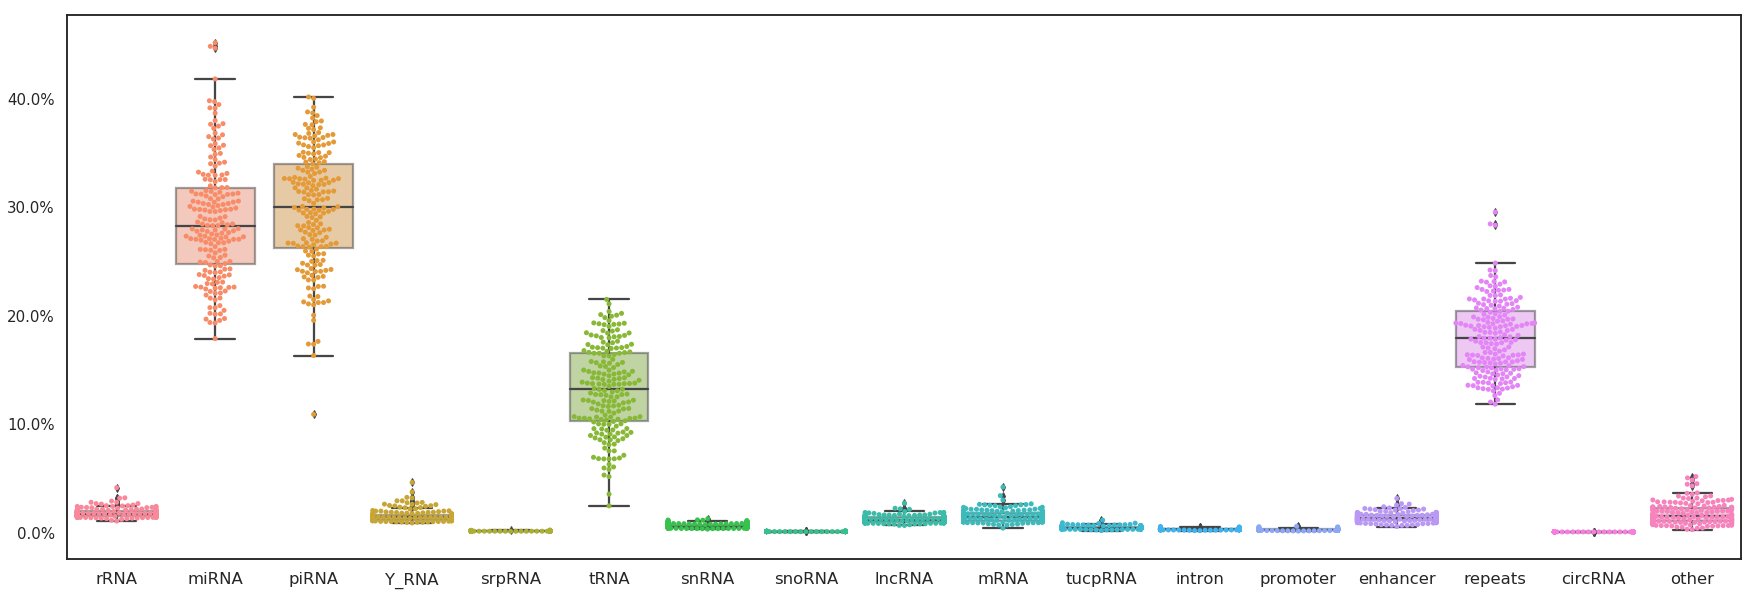

In [7]:
def plot_ratio_boxplot(data, rnanames, points_show = True, width=30, height=10, savefig=False):
    '''
    data: table_ratio
    rnanames: rna type names
    points_show: plot scatter points too
    '''
    fig, ax = plt.subplots(figsize=(width, height))
    sns.boxplot(data = data,ax=ax,boxprops=dict(alpha=.5))
    if points_show:
        sns.swarmplot(data = data,ax=ax)
    #ax.set_title(u'RNA percentage in different samples',fontsize=20)
    ax.set_xticks(range(rnanames.shape[0]))
    ax.set_yticklabels(['{:.1f}%'.format((i-1)*10) for i in range(10)],fontsize=15)
    if savefig:
        fig.savefig(plot_save_path+'rna_ratio_box_plot.png', bbox_inches='tight')
plot_ratio_boxplot(table_ratio, rnanames, points_show = True, width=30, height=10, savefig=False)

## line plot of rna length

In [8]:
def plot_length_line(data, rnanames, width=20, height=50, savefig=False):
    '''
    data: length_table
    rnanames: rna type names
    '''
    length = np.array(data.T)
    fig,ax=plt.subplots(length.shape[0],1,figsize=(width, height))
    for i in range(length.shape[0]):
        ax[i].plot(length[i],label=data.columns[i], color=tableau20[i])
        ax[i].legend(loc='upper right')
        ax[i].set_xticklabels(np.arange(data.index[0]-5, data.index[-1],5))
    if savefig:
        fig.savefig(plot_save_path+'rna_length_line_plot.png', bbox_inches='tight')

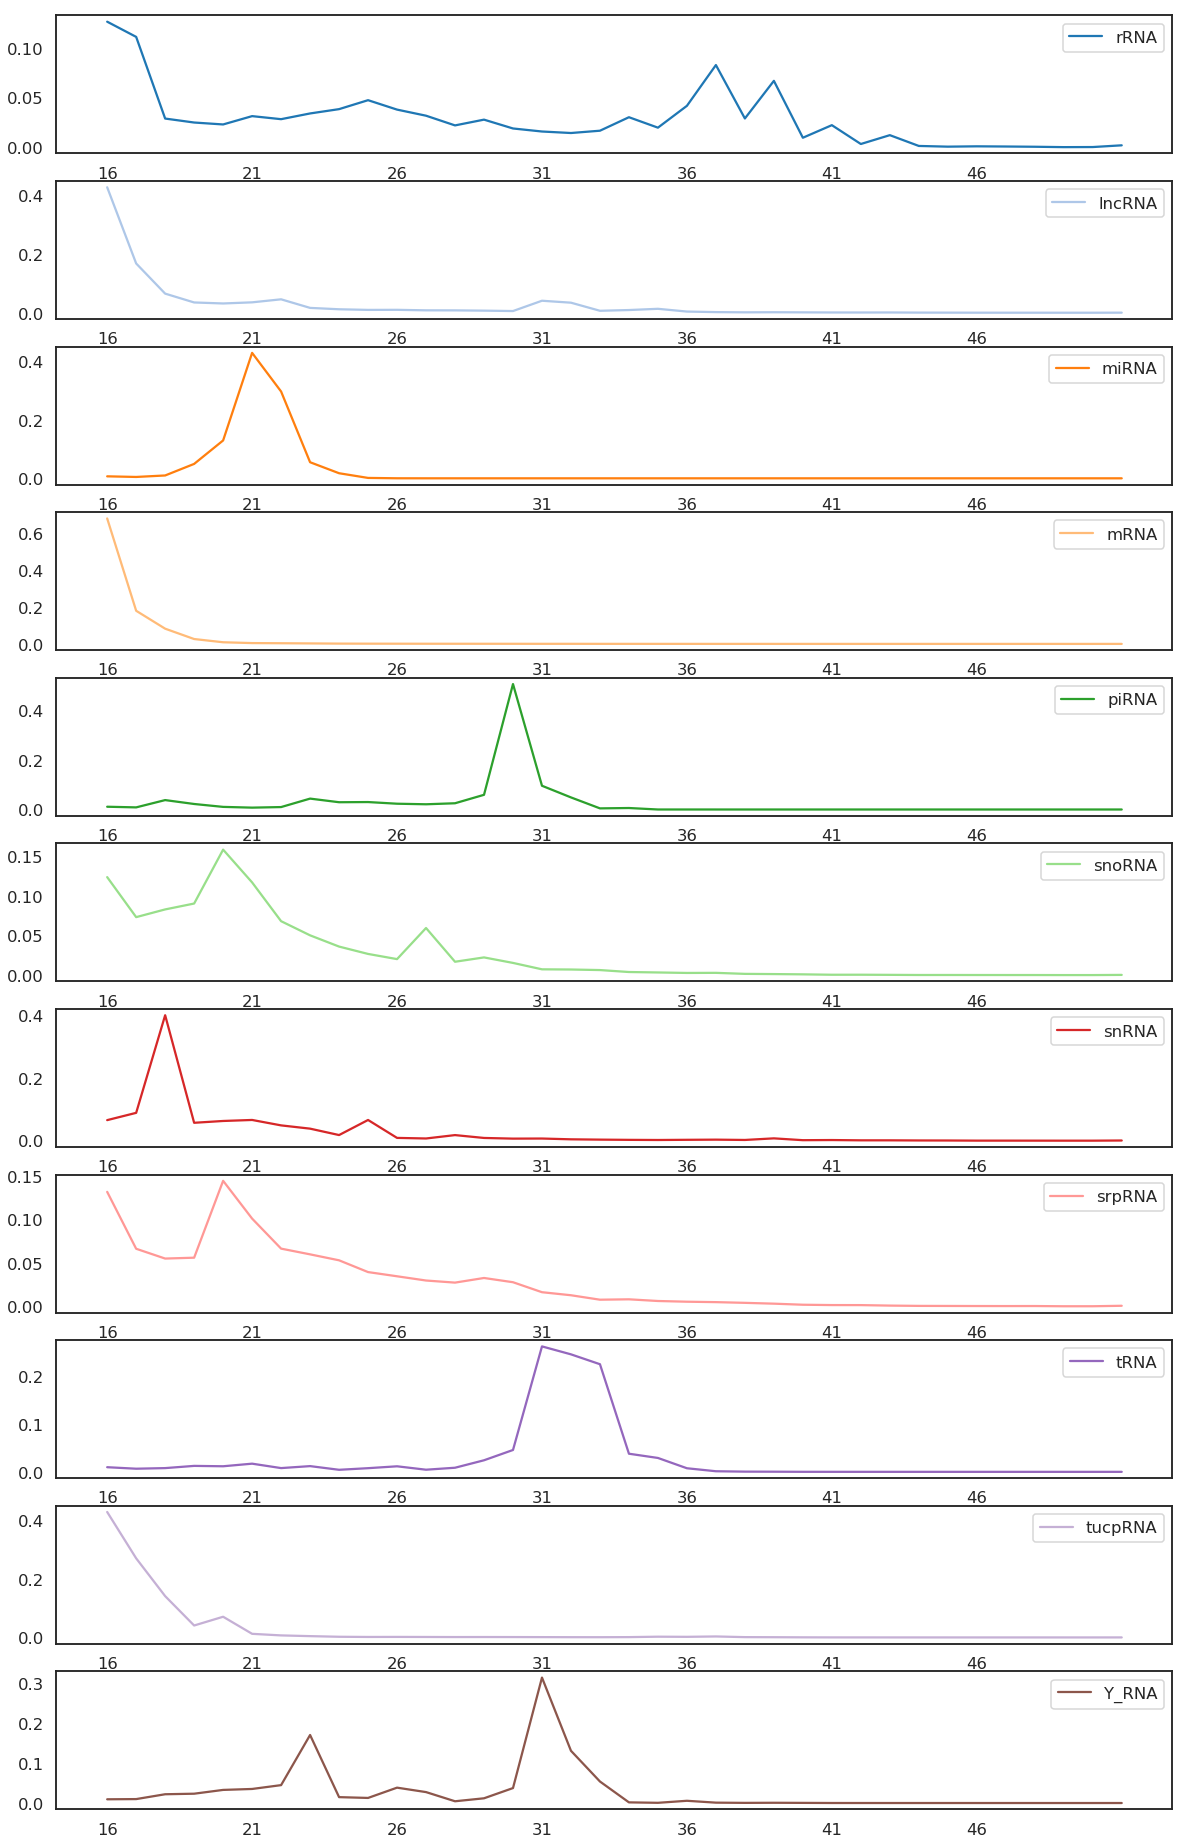

In [9]:
plot_length_line(length_table, rnanames, width=20, height=length_table.shape[1]*3, savefig=False)

## 3D barplot of rna length

In [10]:
def plot_3d(data, width=25, height=16, savefig=False, azim = 45, elev = 32):
    '''
    data: length_table
    '''
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(width,height))
    ax1 = fig.gca(projection="3d")
    num = data.shape[1]
    count_ = data.shape[0]
    xpos = np.repeat(np.arange(1,count_+1),num).reshape(count_,-1).T.ravel()
    ypos = np.repeat(range(num),count_).ravel()
    num_elements = len(xpos)
    zpos = np.zeros(count_*num)
    dx = np.ones(count_*num)/5
    dy = np.ones(count_*num)/5
    dz = np.array(data.T).ravel()
    for i in range(num):
        ax1.bar3d(xpos[count_*i:count_*(i+1)], ypos[count_*i:count_*(i+1)], zpos[count_*i:count_*(i+1)],
                  dx[count_*i:count_*(i+1)], dy[count_*i:count_*(i+1)],dz[count_*i:count_*(i+1)], color=(np.array(tableau20))[:num][i],alpha=0.9)
    plt.xticks(range(count_), [str(i+16) for i in range(count_)], color='red')
    ax1.set_yticks(range(num))
    ax1.set_yticklabels(data.columns, color='blue')
    for color,tick in zip((np.array(tableau20)/float(256))[:num],ax1.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    ax1.view_init(azim=azim,elev=elev)  
    fig.tight_layout()
    if savefig:
        fig.savefig(plot_save_path+'rna_length_3D_barplot.png', bbox_inches='tight')

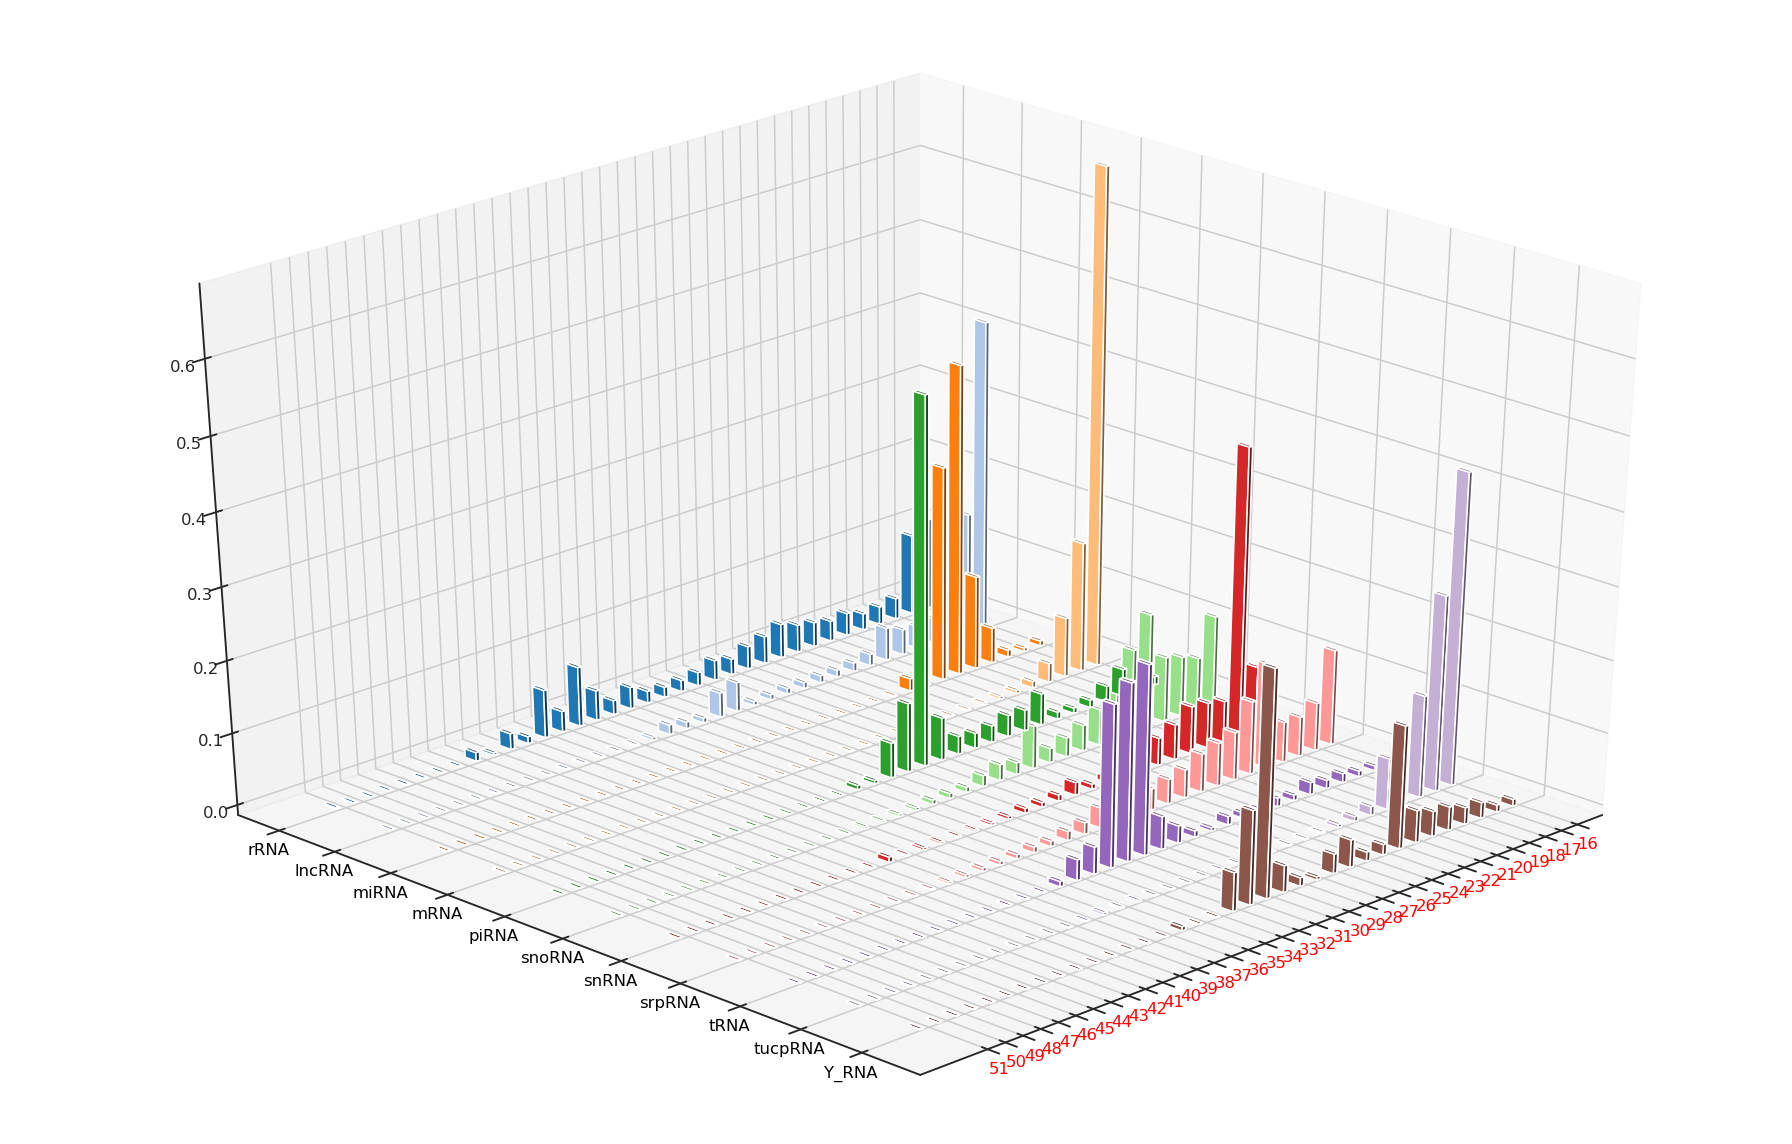

In [11]:
plot_3d(length_table, width=25, height=16, savefig=False, azim = 45, elev = 32)

## stack bar plot of rna counts and ratio

In [12]:
def stack_bar_ratio(table, statistics = 'ratio',savefig=False):
    from matplotlib.colors import LinearSegmentedColormap
    fig,ax=plt.subplots(figsize=(50,10))
    table.plot(kind='bar', stacked=True,ax=ax,
                legend=True,colormap=matplotlib.colors.ListedColormap ( tableau20))
    ax.legend(bbox_to_anchor=(1,1),fontsize='large')#, loc="lower right",
    #ax.set_title('Stacked Bar plot',fontsize=40)
    if savefig:
        fig.savefig(plot_save_path+statistics+'_stack_barplot.png', bbox_inches='tight')

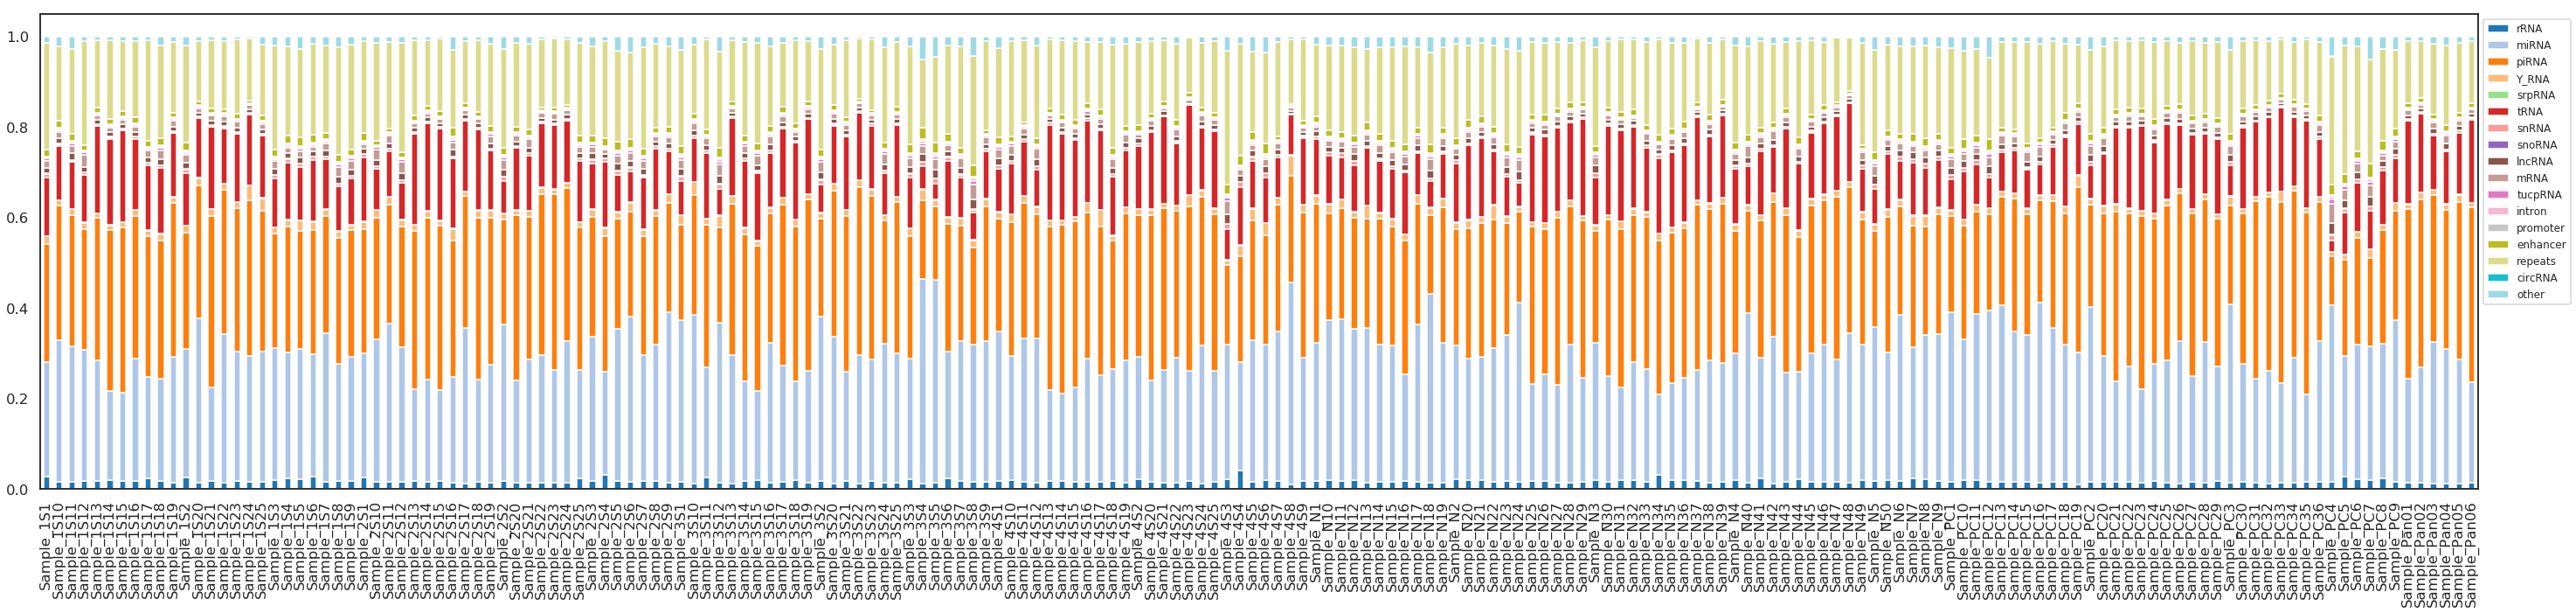

In [13]:
stack_bar_ratio(table_ratio)

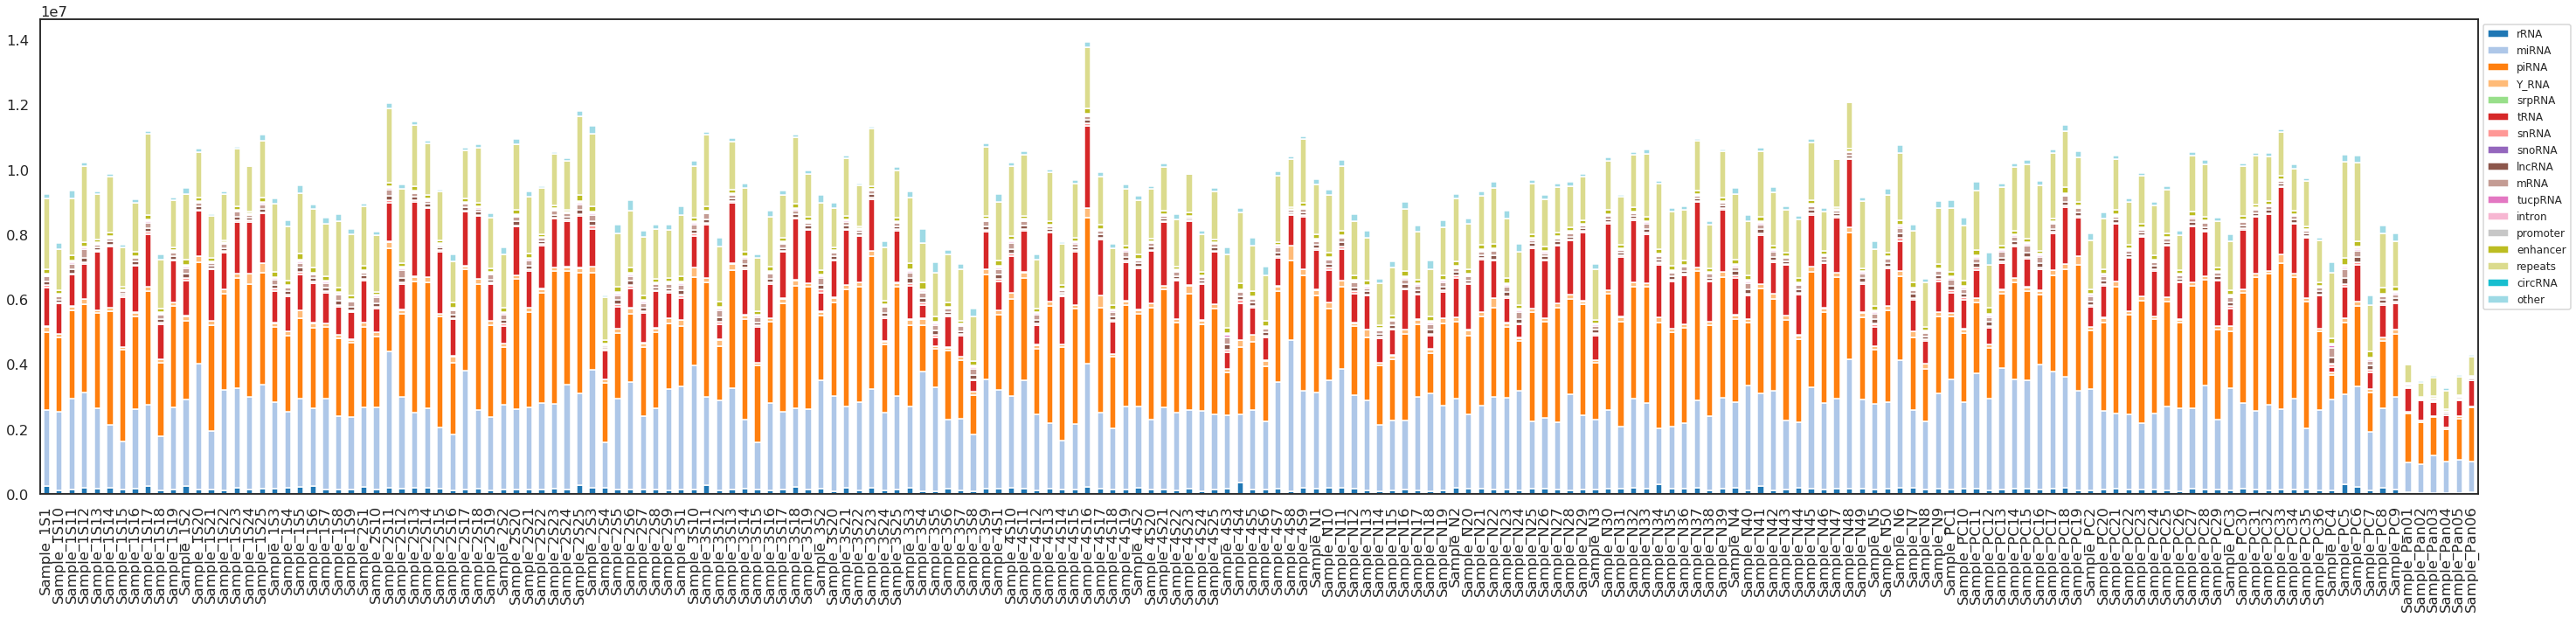

In [14]:
stack_bar_ratio(table_count)

## bar plot of RNA by sample

In [15]:
def plot_bar_by_rna(table,rnaname,savefig=False, statistics = 'ratio',height = 20, width=4):
    '''
    table: ratio or count table, rows are rna type
    statistics: ratio or count
    '''
    table = table.T
    count = np.array(table[table.index ==rnaname]).ravel()
    fig,ax=plt.subplots(1,figsize=(height, width))
    counttable =  pd.DataFrame(np.concatenate((np.arange(1,table.shape[1]+1).reshape(-1,1),
                count[np.argsort(-count)].reshape(-1,1)),axis=1),columns=['sample',statistics])
    sns.barplot(x='sample',y=statistics,data = counttable,color=tableau20[np.random.randint(0,20)],alpha=1)
    ax.set_xticks(np.arange(0,table.shape[1],5))
    ax.set_xticklabels(np.arange(0,table.shape[1],5))
    ax.set_title(statistics+' of '+rnaname,fontsize=15)
    if savefig:
        fig.savefig(plot_save_path+'sample_'+rnaname+'_'+statistics+'_bar_plot.png', bbox_inches='tight')

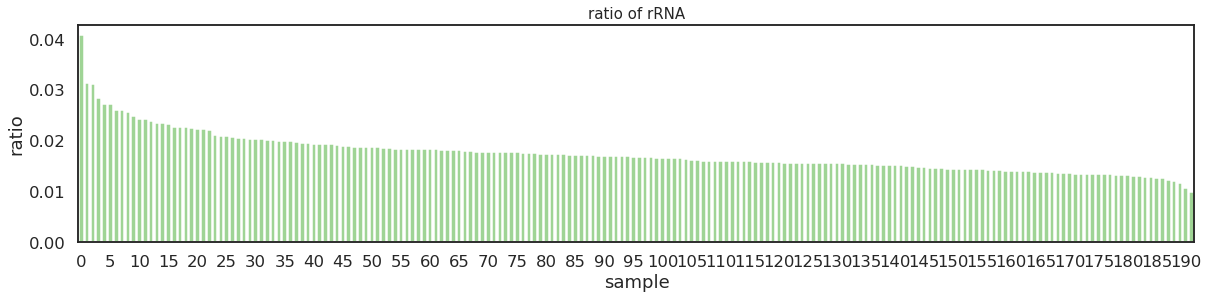

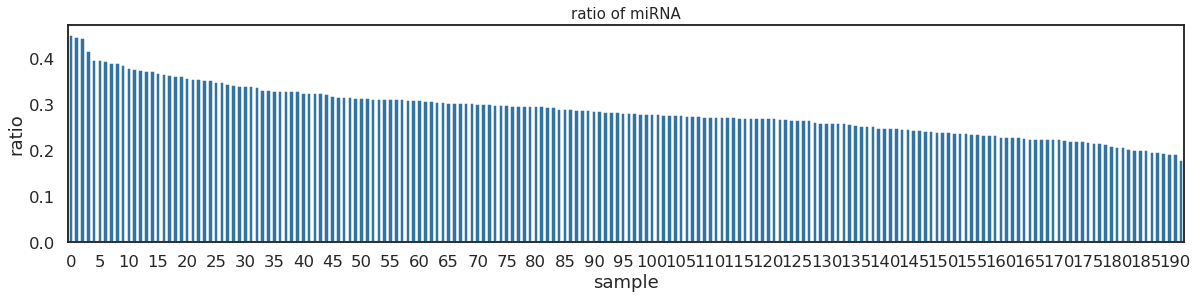

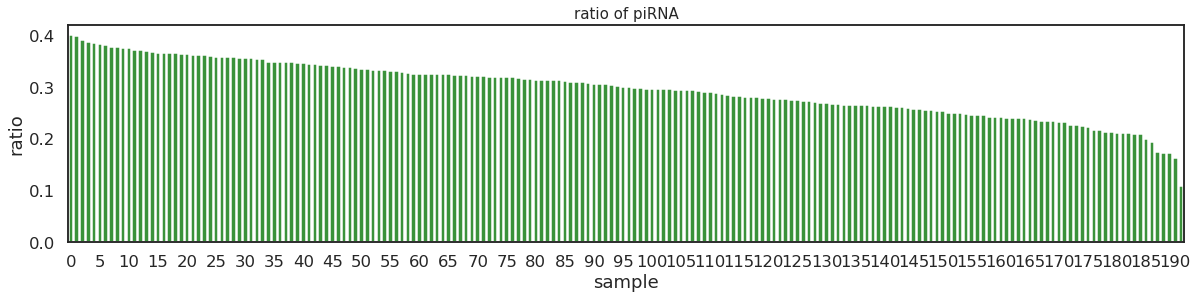

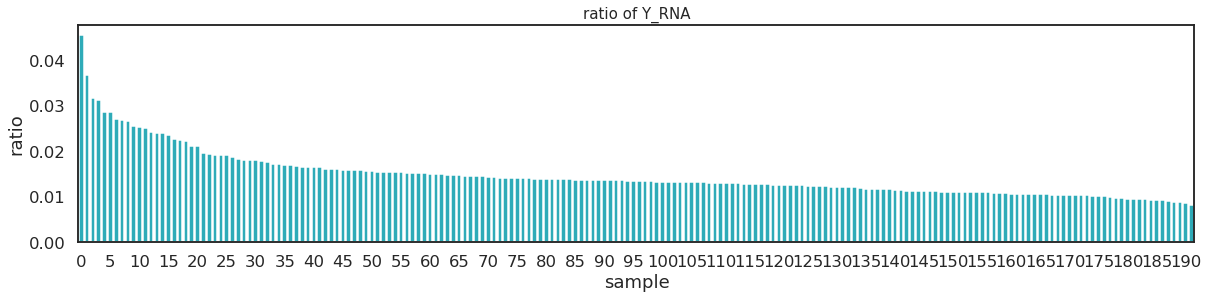

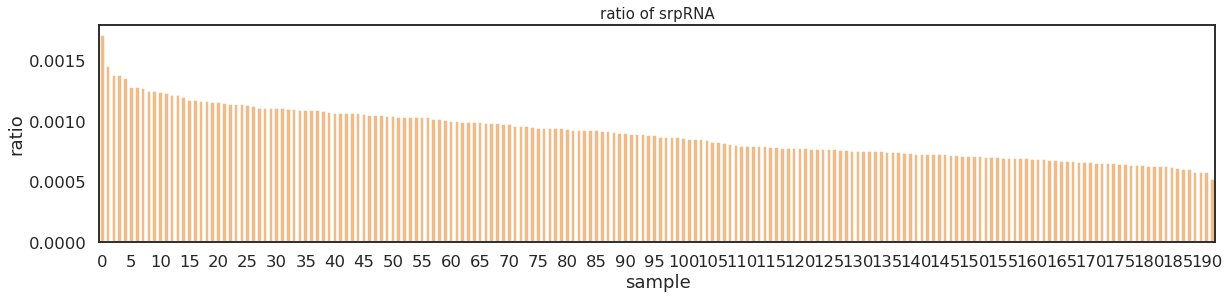

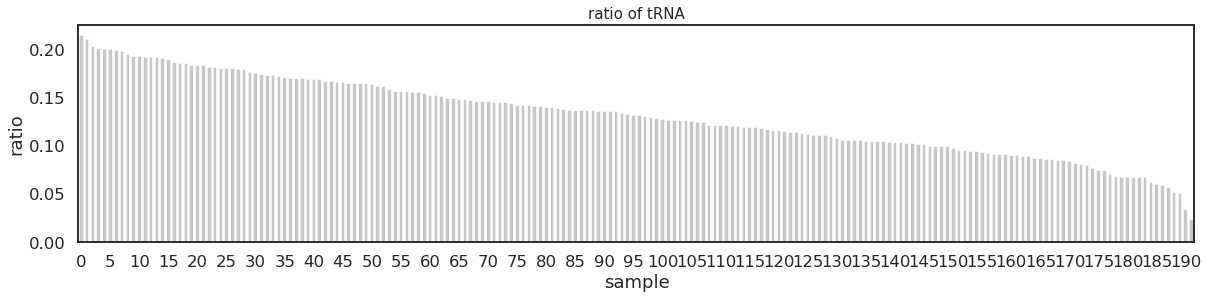

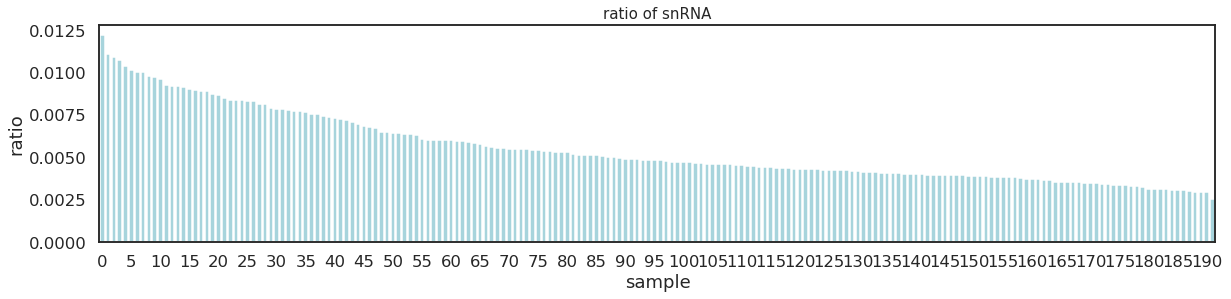

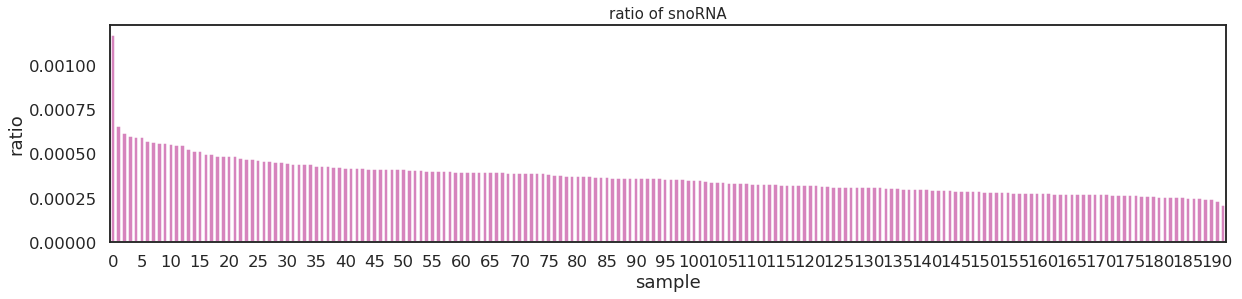

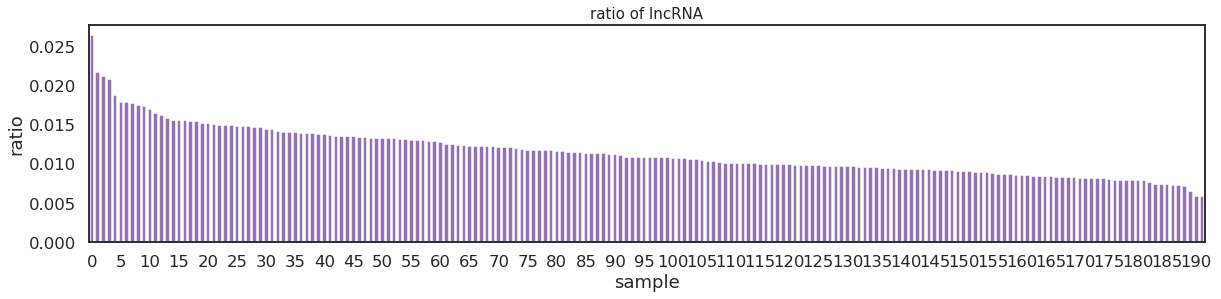

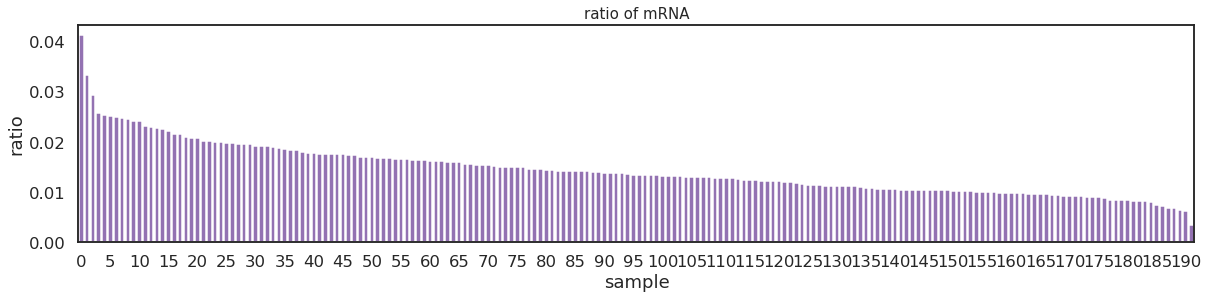

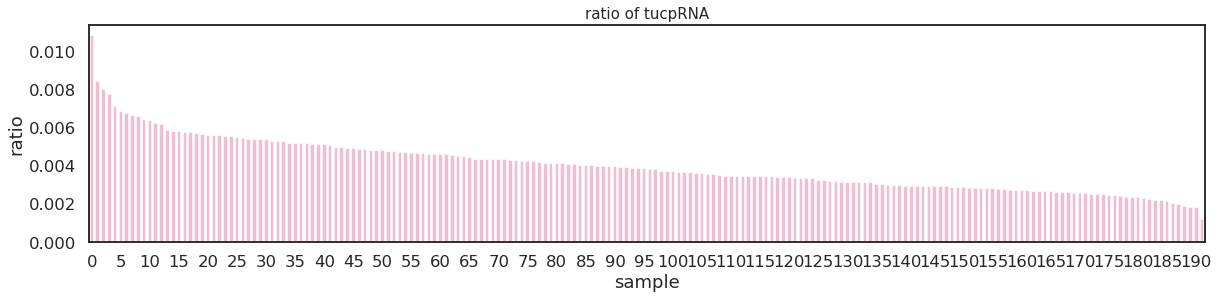

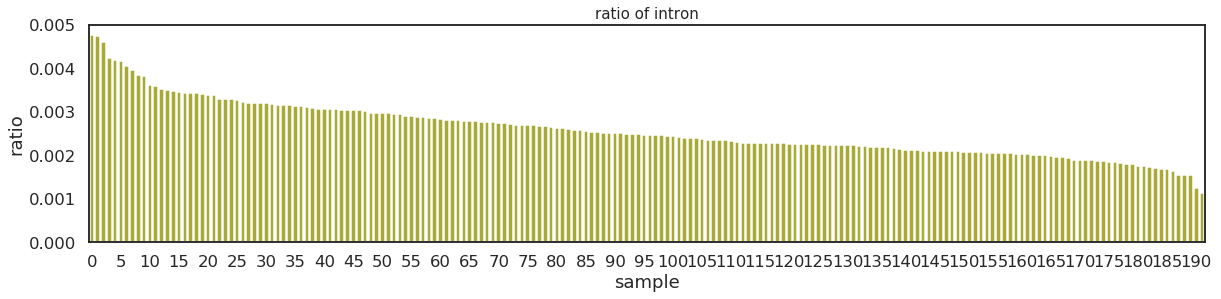

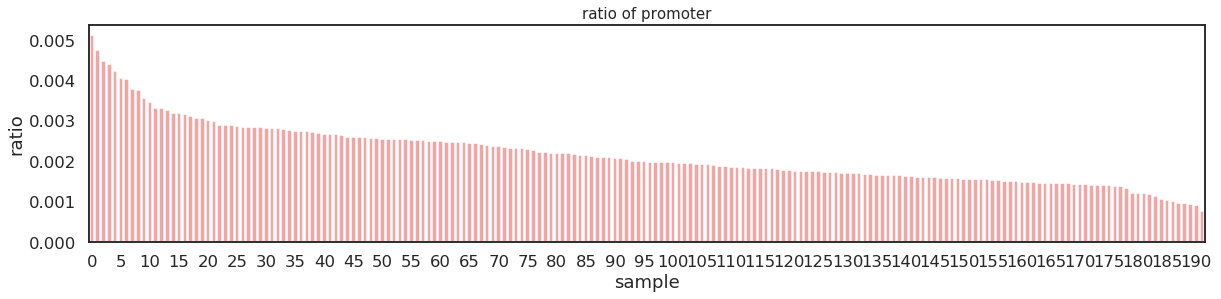

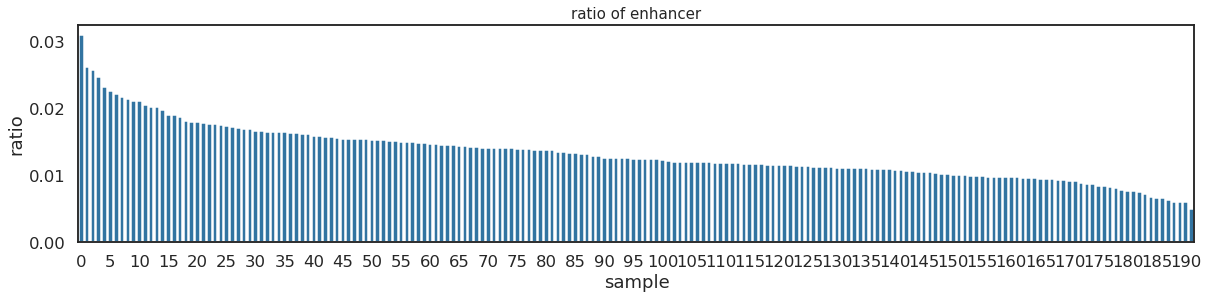

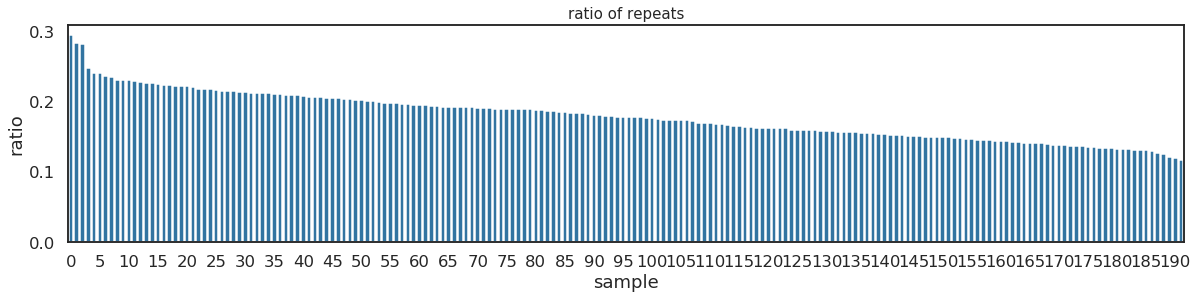

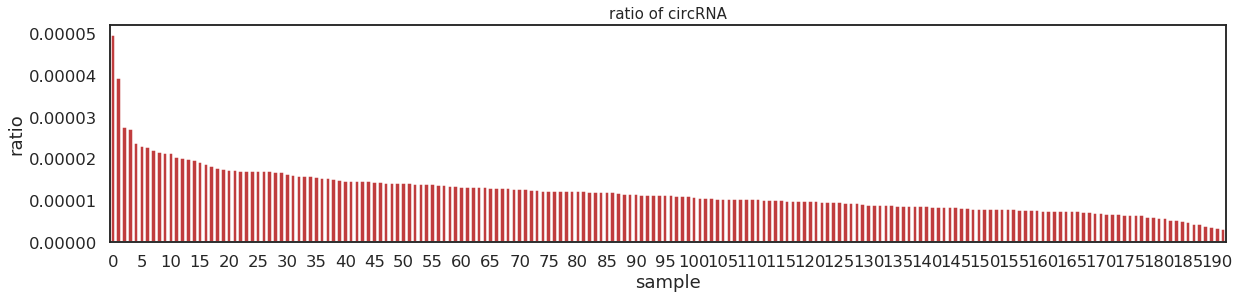

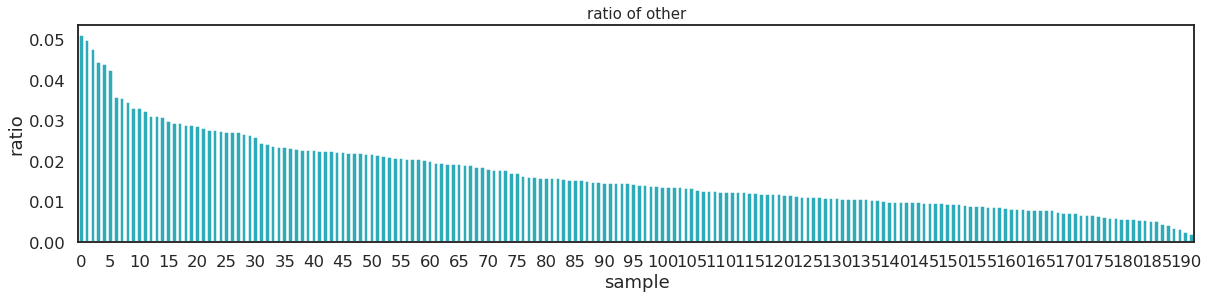

In [16]:
for i in table_ratio.columns:
    plot_bar_by_rna(table_ratio,i,statistics = 'ratio')

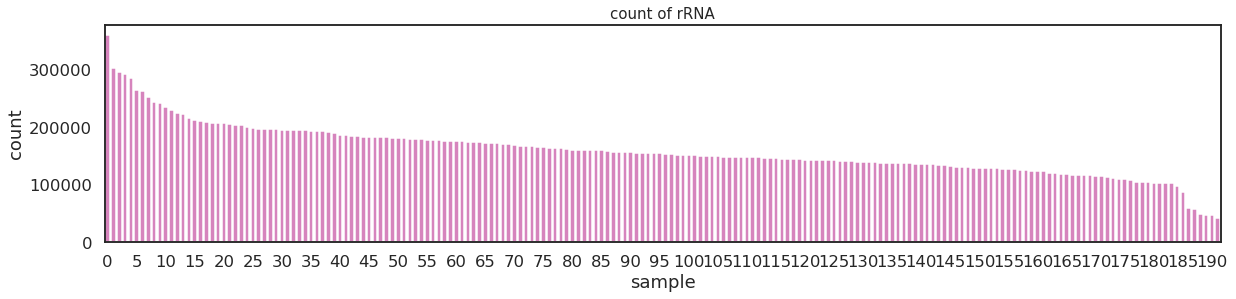

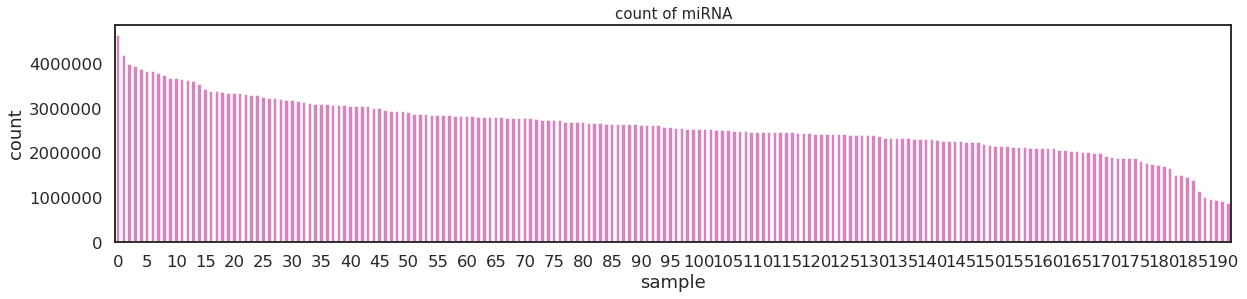

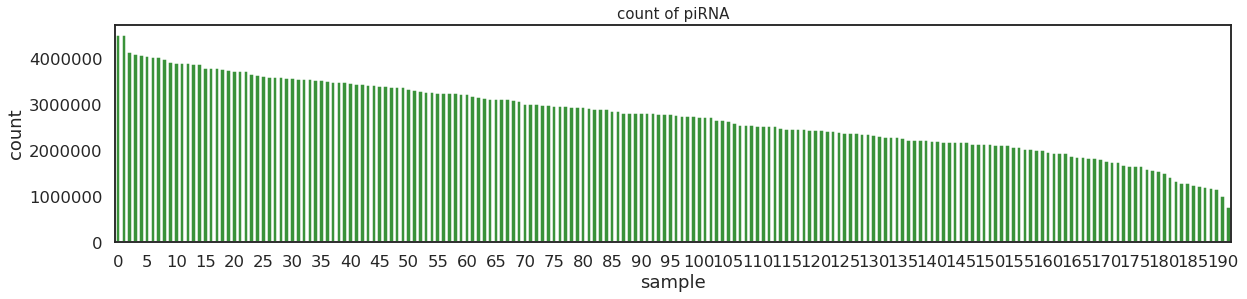

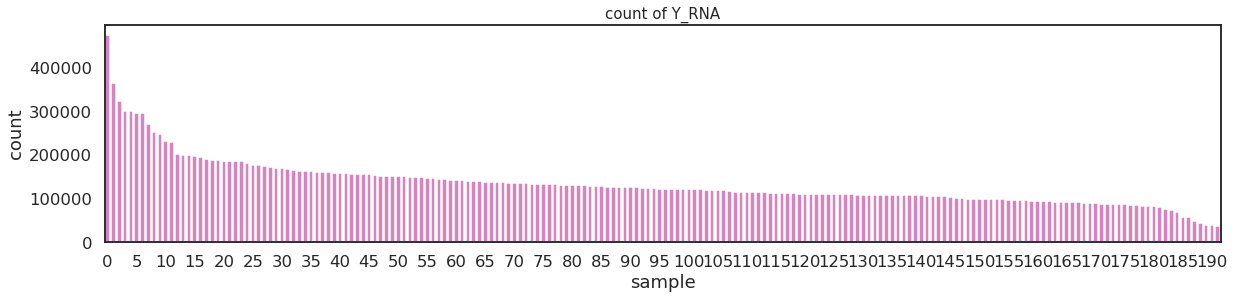

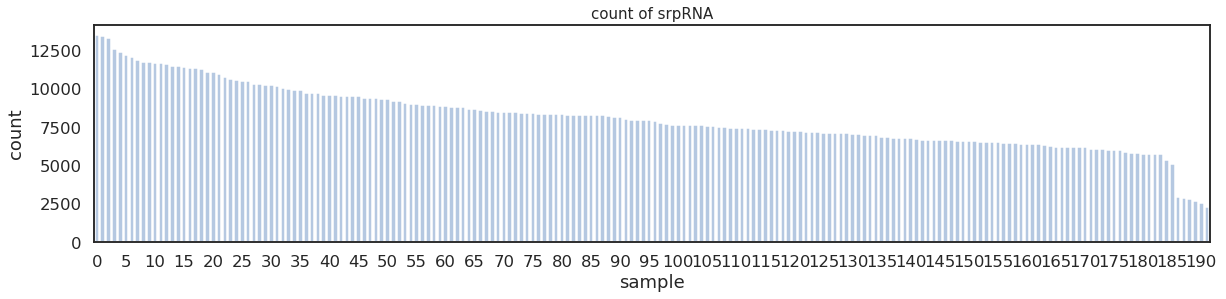

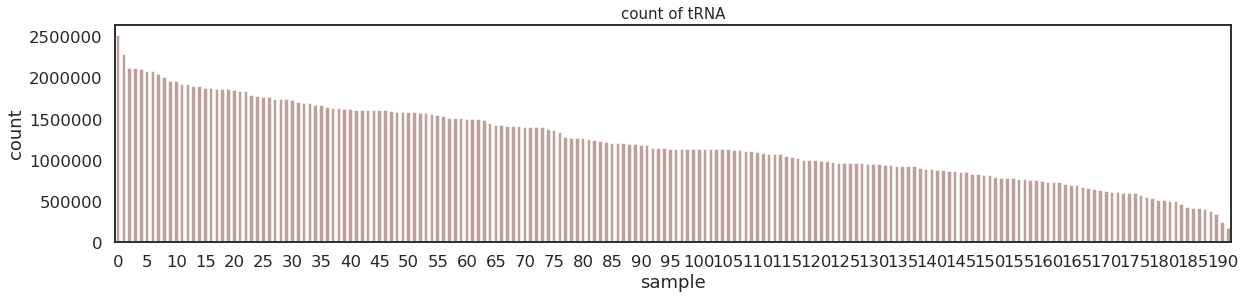

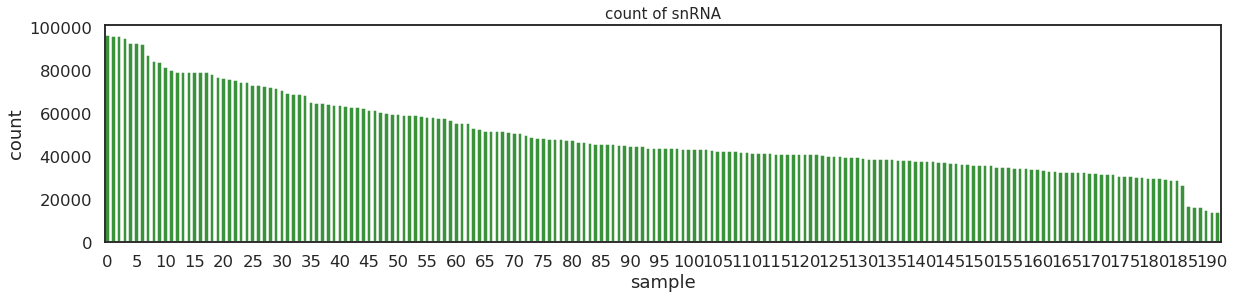

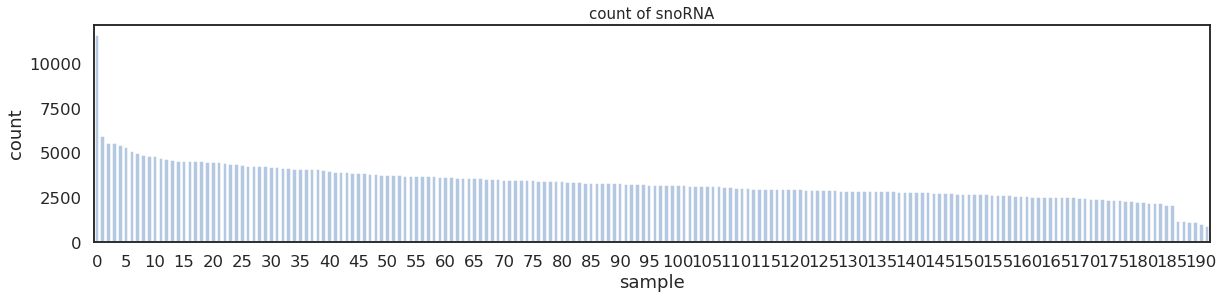

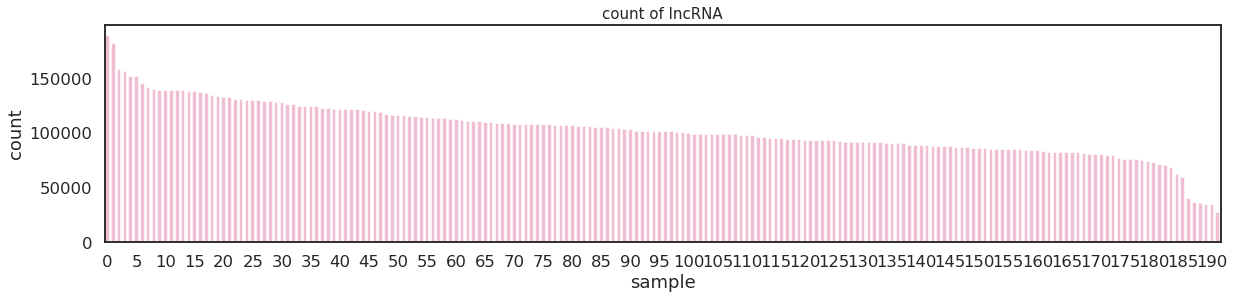

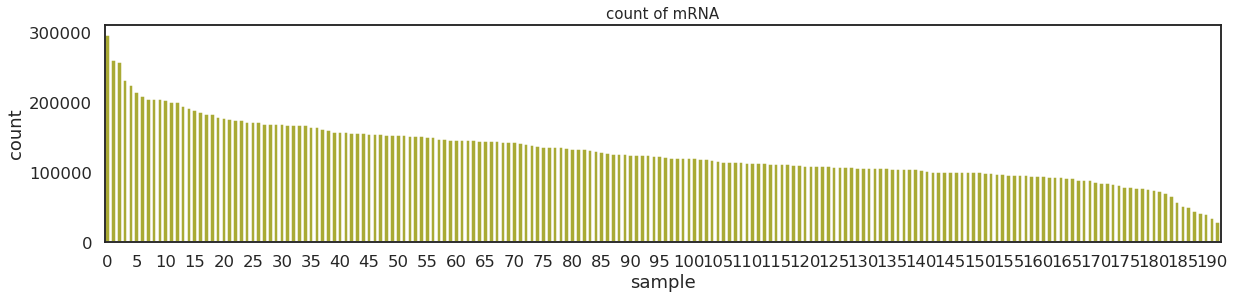

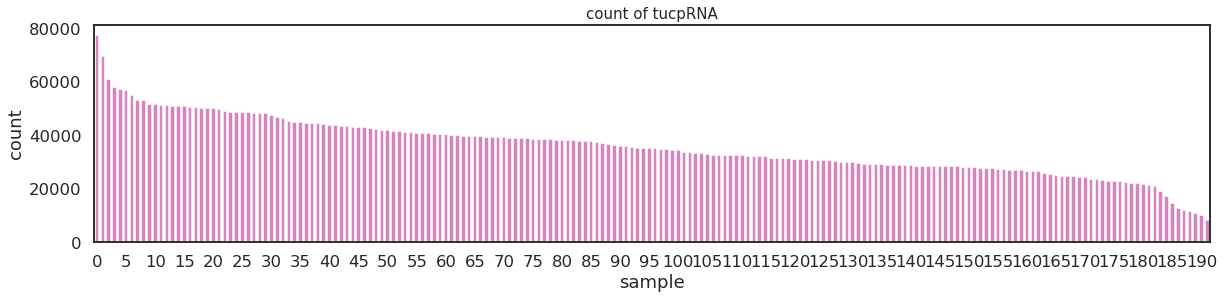

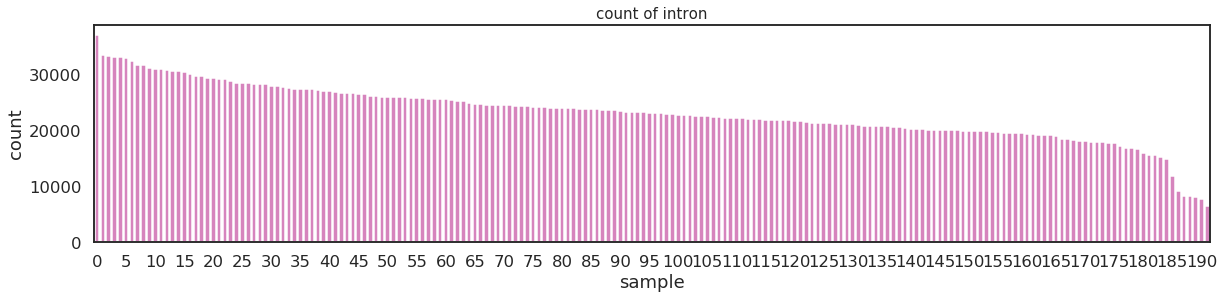

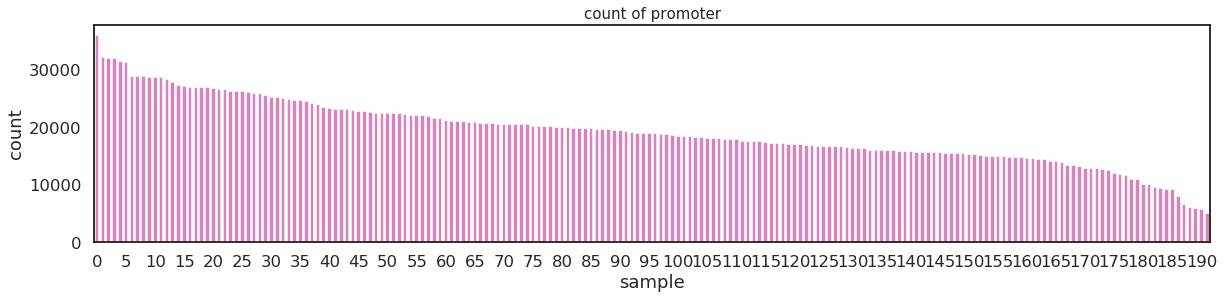

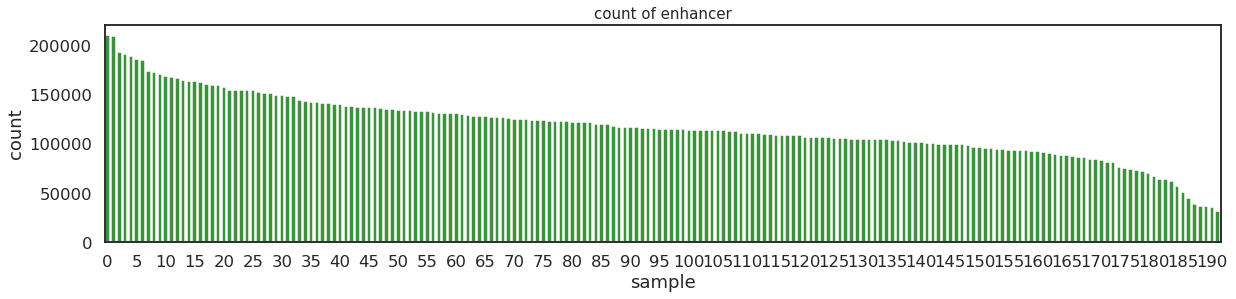

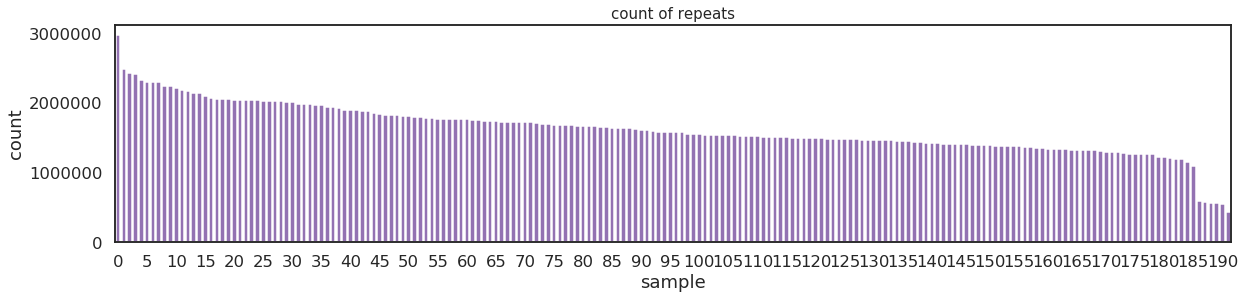

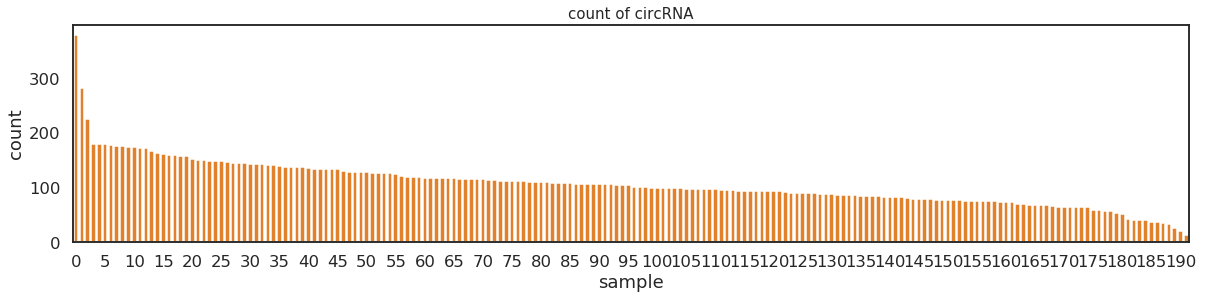

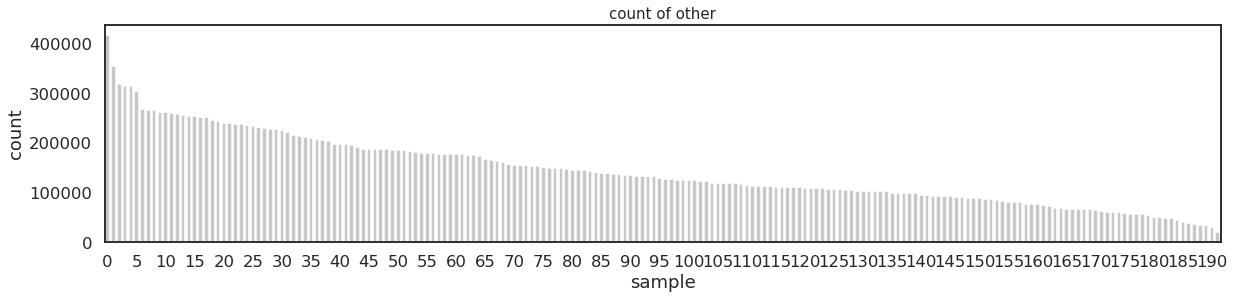

In [17]:
for i in table_count.columns:
    plot_bar_by_rna(table_count,i,statistics = 'count')

# Matrix processing

In [18]:
original_mx_file = 'output/scirep/count_matrix/transcript.txt'
matrix_processing_path = 'output/scirep/matrix_processing/'
imputation_method = 'null'
normalization_method = 'Norm_null'
batch_removal_method = 'Batch_Combat'
batch_index = '1'
class_info = 'data/labels/scirep_classes.txt'
batch_info = 'data/other_annotations/scirep_batch.txt'

In [20]:
def null_name(string):
    if string =='null':
        return '.null'
    else:
        return '.'+string

In [21]:
def generate_processed_filename(original_mx_file,imputation_method,normalization_method,batch_removal_method,batch_index): 
    imputename = null_name(imputation_method)
    normname = null_name(normalization_method)
    batchname = null_name(batch_removal_method)
    if batch_index=='null':
        batchindname = 'null'
    else:
        batchindname = '_'+batch_index
    return'filter'+imputename+normname+batchname+batchindname+'.'+original_mx_file.split('/')[-1]

In [22]:
original_mx = pd.read_table(original_mx_file,index_col=0)
processed_mx = pd.read_table(matrix_processing_path+generate_processed_filename(\
            original_mx_file,imputation_method,normalization_method,batch_removal_method,batch_index),index_col=0)

In [23]:
sample_class = pd.read_table(class_info,sep='\t',index_col=0)

## distribution 
before and after normalization and batch removal from R

In [ ]:
from IPython.display import Image
Image(filename='test.png') 

## PCA and tSNE

In [24]:
def alignment_score(X, y, K=10):
    N = X.shape[0]
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)
    print (same_class_fractions.shape,np.mean(same_class_fractions),K/N,neighbor_classes)
    return score
def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

In [25]:
def PCA_plot_with_alignment_score(ax,data,sampleclass,method_PCA = True):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    class_name = np.unique(sampleclass.label)
    #fig, ax = plt.subplots(figsize=(10, 10))
    for label, color in zip(class_name, 
                                tableau20[:class_name.shape[0]]):
        indices = np.nonzero(sampleclass.loc[data.columns].label == label)[0]
        ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=200,alpha=0.8 ,edgecolors = 'b',label=label)
    ax.legend(fontsize=10)
    ax.set_title('Alignment score: {:.6f}'.format(knn_score(X, sampleclass.loc[data.columns.values].values.ravel() )))
    print('Alignment score: {}'.format(knn_score(X, sampleclass.loc[data.columns.values].values.ravel() )))
    return knn_score(X, sampleclass.loc[data.columns.values].values.ravel() )

Alignment score: 0.006017213306478457
Alignment score: 0.012415778907925537


0.012415778907925537

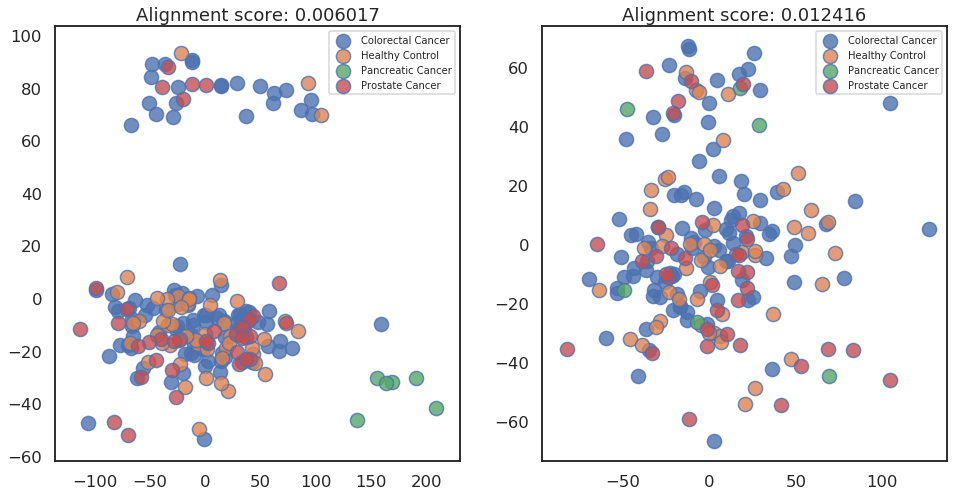

In [26]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))
PCA_plot_with_alignment_score(ax[0],original_mx,sample_class,method_PCA = True)
PCA_plot_with_alignment_score(ax[1],processed_mx,sample_class,method_PCA = True)

## top K
- cumulative
- top k feature from R

### cumulative

In [27]:
def topk_cumsum_plot(data, topk=20):
    total_sum = data.sum().sum()
    cumsumvalue = np.cumsum(- np.sort(- np.sum(original_mx,axis=1))/total_sum)
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.bar(np.arange(0,topk),cumsumvalue[:topk],color='r',alpha=0.5)
    ax.set_xticks(np.arange(0,topk))
    ax.set_xticklabels(np.arange(1,1+topk))
    ax.set_title('cumulative bar plot of top '+str(topk)+' feature')

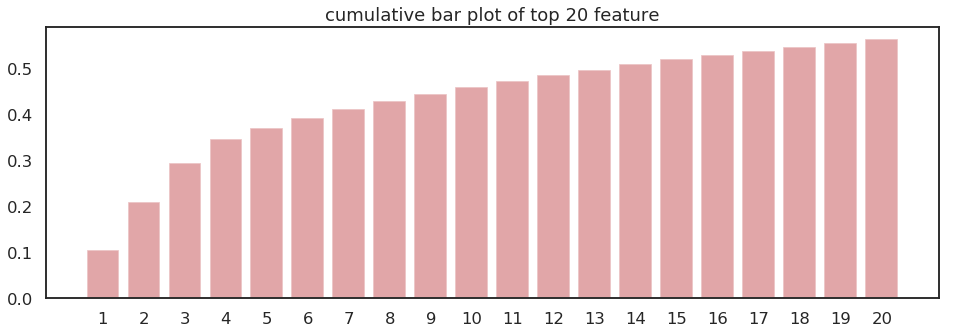

In [28]:
topk_cumsum_plot(processed_mx,topk=20)

### top k feature from R

In [ ]:
from IPython.display import Image
Image(filename='test.png') 

## SCnorm 
from R


In [ ]:
from IPython.display import Image
Image(filename='test.png') 

## show batch
- counts
- by rna

In [29]:
batchtable = pd.read_table(batch_info,sep='\t',index_col=0)

In [30]:
def show_batch_total_counts(ax,batchtable,matrix, batchindex = 1):
    counts = matrix.sum()
    sumtable = pd.DataFrame(counts,columns=['total counts'])
    sumtable_whole = pd.concat((sumtable,batchtable.loc[sumtable.index]),axis=1)
    #fig,ax=plt.subplots(figsize=(8,6))
    batchname = batchtable.columns[batchindex]
    sns.boxplot(data=sumtable_whole,x=batchname,y='total counts',ax=ax)
    ax.set_title('Batch effect: '+batchname)

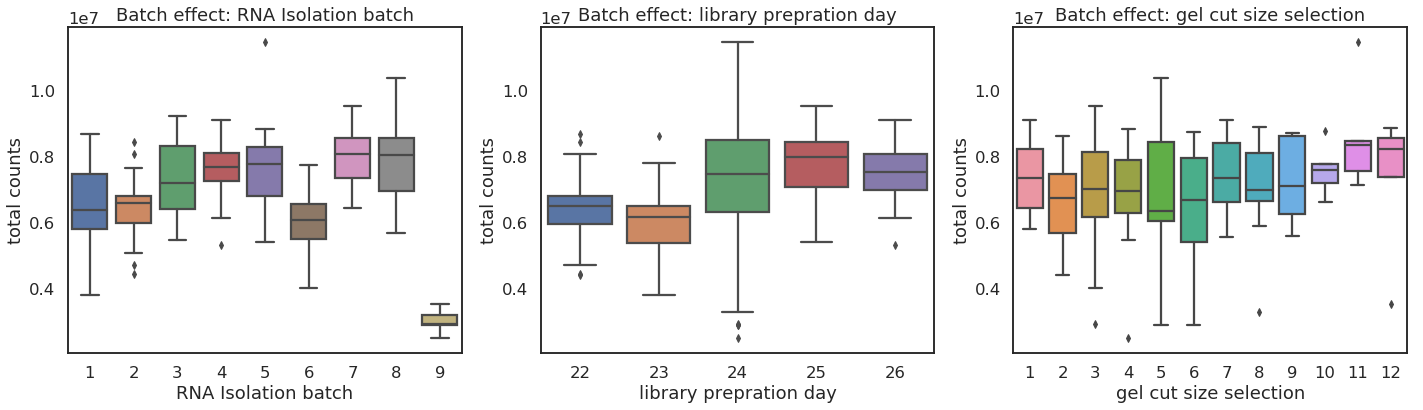

In [31]:
fig, ax = plt.subplots(1,3,figsize=(24, 6))
for  i in range(3):
    show_batch_total_counts(ax[i],batchtable, original_mx, batchindex = i)

In [32]:
def plot_rna_batch(ax,rnaname,typetable,batchtable,batchindex=1):
    '''
    typetable: table_ratio
    rnaname certain type pf rna
    '''
    counts = typetable.T.loc[rnaname].T
    sumtable = pd.DataFrame(counts)
    sumtable_whole = pd.concat((sumtable.loc[batchtable.index],batchtable),axis=1)
    batchname = batchtable.columns[batchindex]
    sns.boxplot(data=sumtable_whole,x=batchname,y=rnaname,ax=ax)
    ax.set_title('batch effect: '+batchname+ ' by '+rnaname,size=16)
    plt.tight_layout()

In [33]:
rnanames

array(['rRNA', 'miRNA', 'piRNA', 'Y_RNA', 'srpRNA', 'tRNA', 'snRNA',
       'snoRNA', 'lncRNA', 'mRNA', 'tucpRNA', 'intron', 'promoter',
       'enhancer', 'repeats', 'circRNA', 'other'], dtype='<U8')

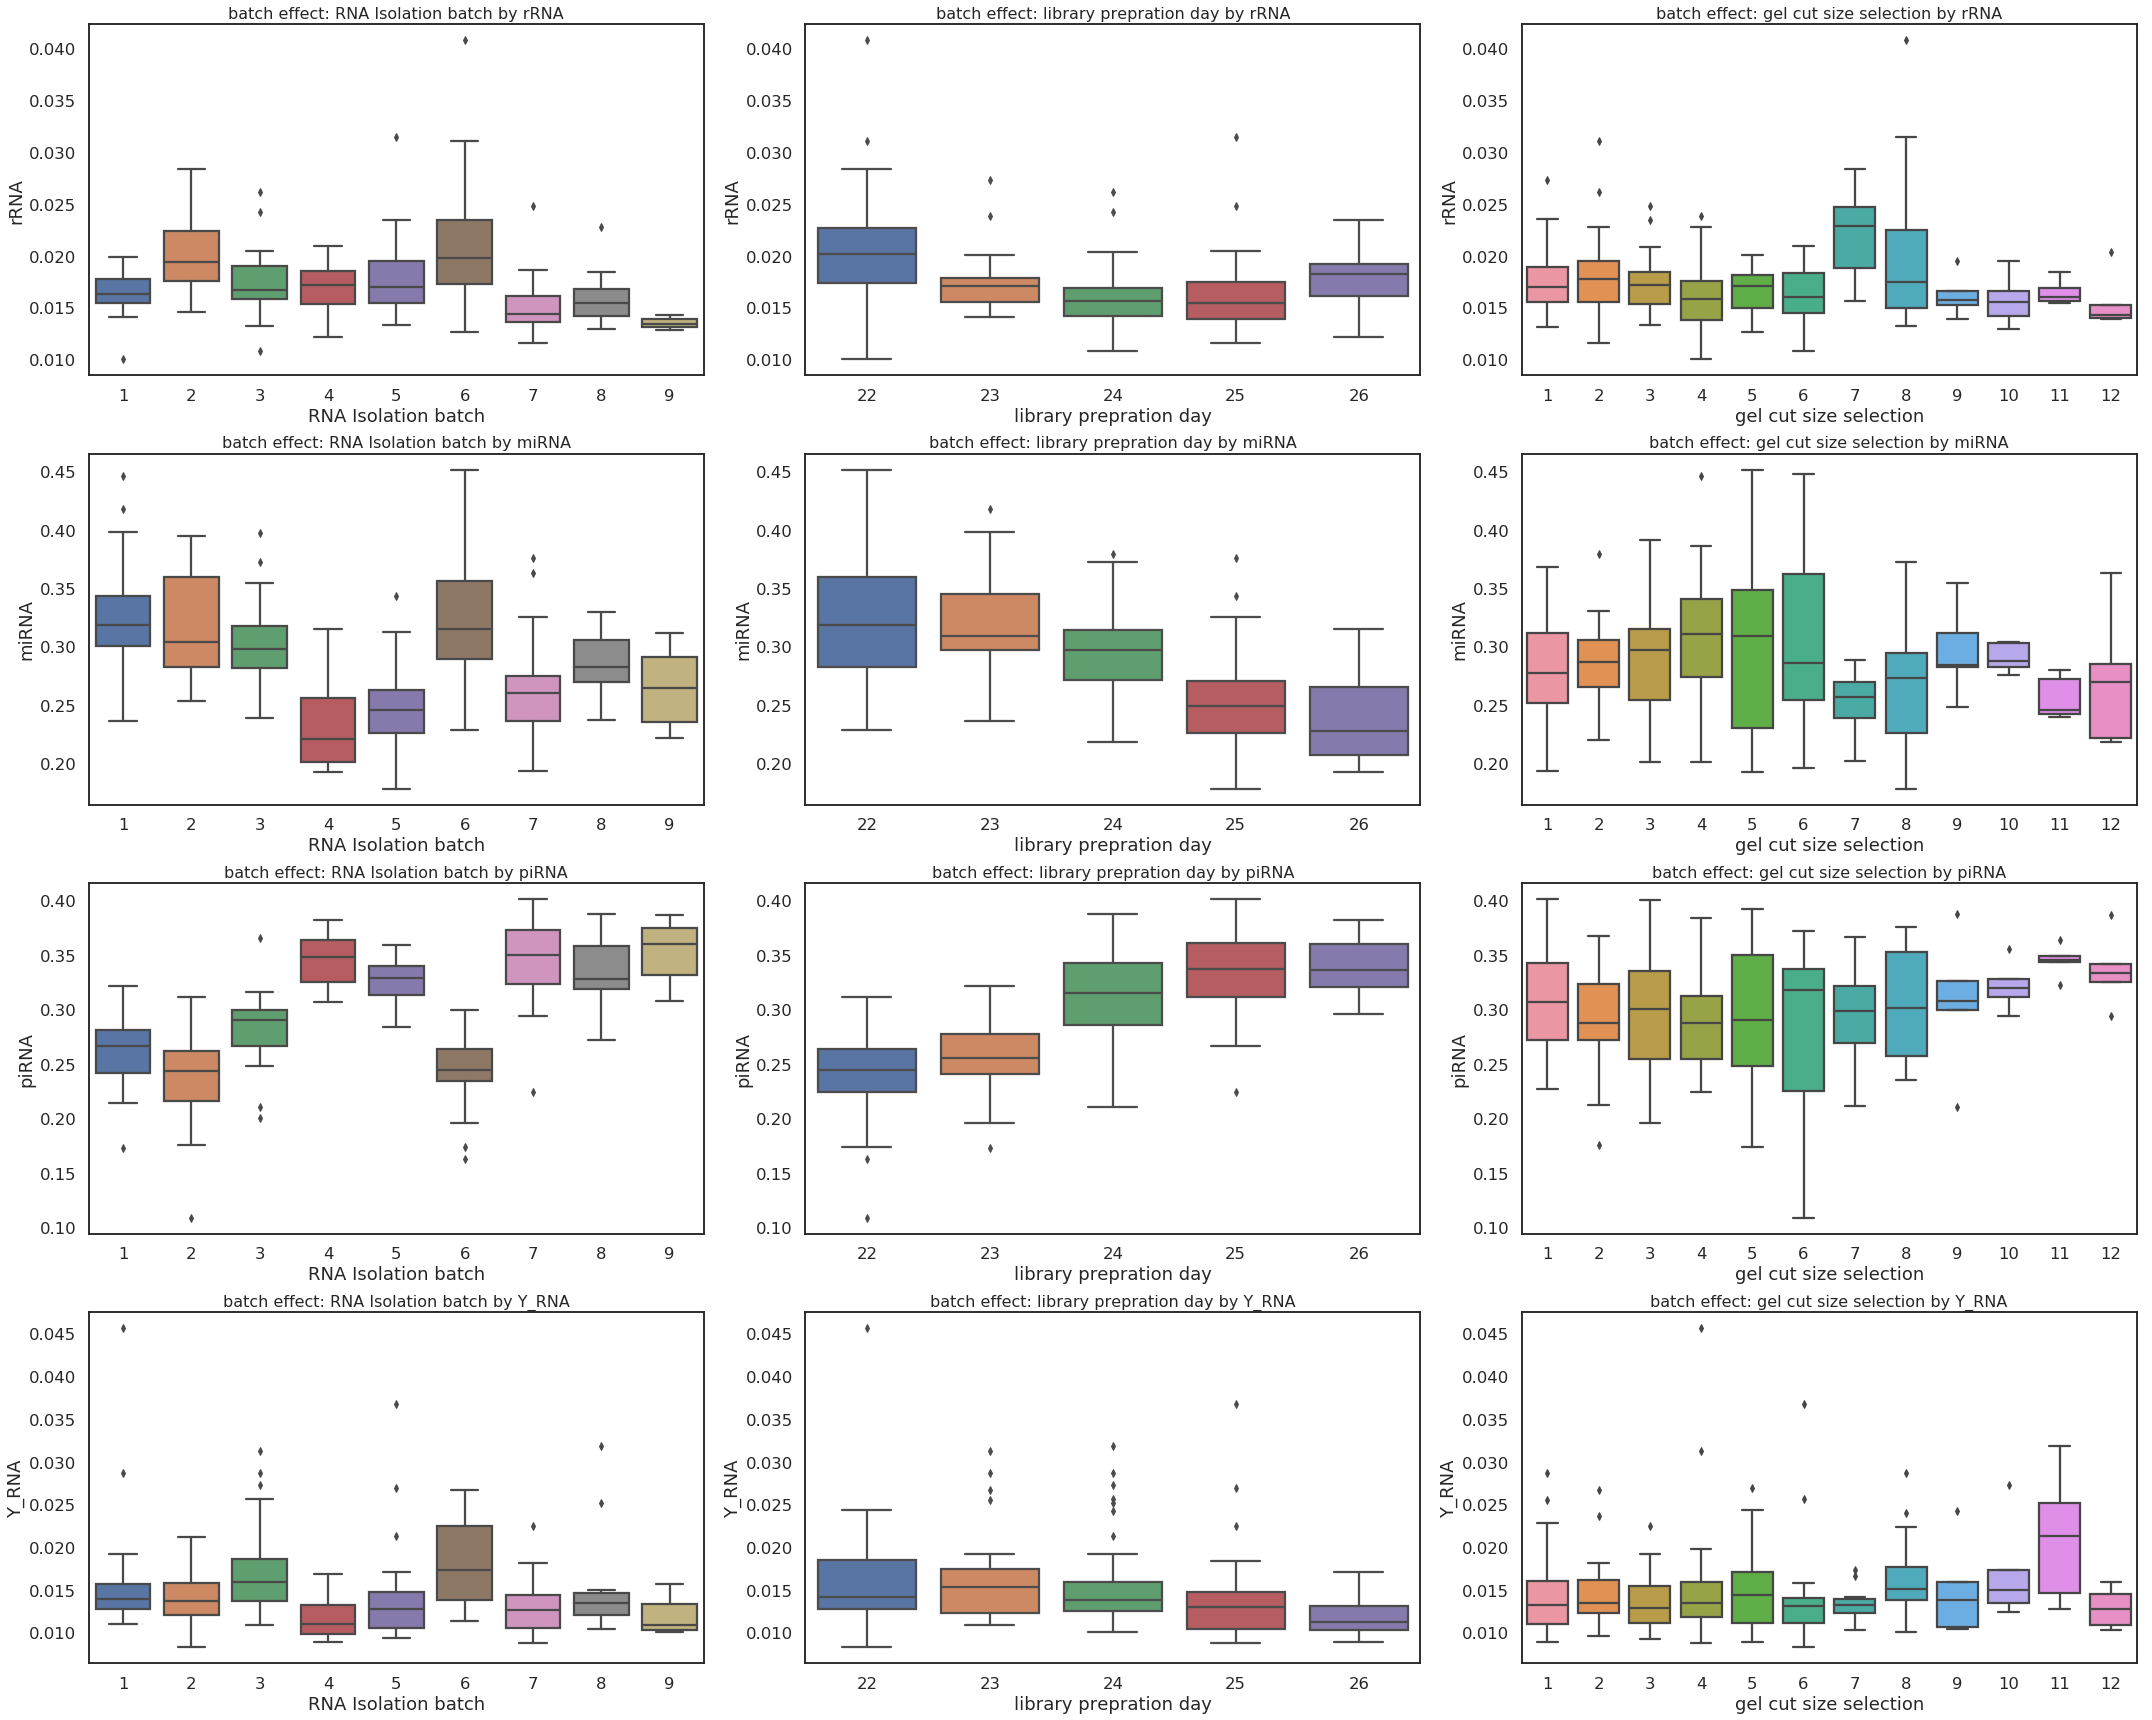

In [34]:
fig, ax = plt.subplots(4,3,figsize=(30, 24))
for i in range(4):
    for j in range(3):
        plot_rna_batch(ax[i,j],rnanames[i],table_ratio,batchtable,batchindex=j)

## reference gene

In [35]:
reference_gene_file = 'data/matrix_processing/refer_gene_id.txt'
reference_gene_list = np.loadtxt(reference_gene_file,dtype='str')

In [36]:
def plot_reference_box(matrix,reference_gene_list):
    fig,ax=plt.subplots(figsize=(20,8))
    index_0 = np.array([matrix.index[i].split('|')[0] for i in range(matrix.shape[0])])
    table = matrix.iloc[np.isin(index_0 ,reference_gene_list)]
    index_3_refer = np.array([table.index[i].split('|')[2] for i in range(table.shape[0])])
    nonnan = np.where(np.sum(pd.isna(table),axis=1)==0)[0]
    table = table.iloc[nonnan,:]
    table_log =  np.log2(table+1)
    #sns.boxplot(data = table.T,ax=ax)
    #stdscale = StandardScaler()
    sns.violinplot(data =table_log.T,ax=ax)
    ax.set_xticklabels(index_3_refer[nonnan])
    cv = np.std(table_log,axis=1)/np.mean(table_log,axis=1)
    cv_labels  = np.array([str(np.round(s, 2)) for s in cv])
    pos = range(cv.shape[0])
    medians = np.max(table_log.T)
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 1.0, cv_labels[tick], 
            horizontalalignment='center', size='x-small', color='b', weight='semibold')
    ax.set_title('Reference genes')

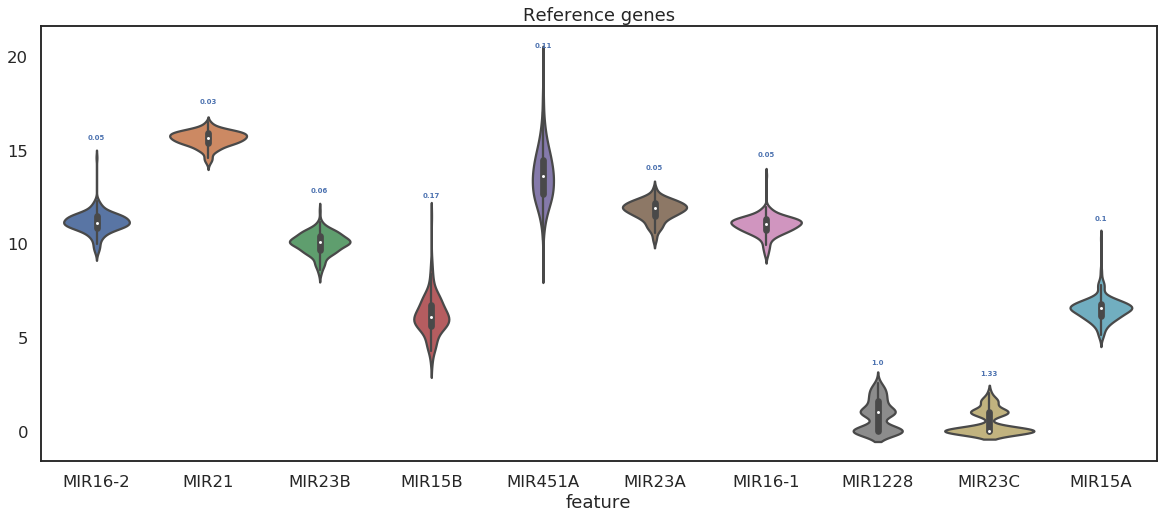

In [37]:
plot_reference_box(original_mx,reference_gene_list)

### plot density
from R 

In [ ]:
from IPython.display import Image
Image(filename='test.png') 

## boxplot and variance plot
from R

In [ ]:
from IPython.display import Image
Image(filename='test.png') 

# Evaluation

## ROC

In [38]:
jack_roc_file = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/transcripts_exrna/Normal-HCC/logistic_regression.50.robust.leave_one_out'
shuffle_split_roc_file = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/transcripts_exrna/Normal-HCC/random_forest.50.rfe.stratified_shuffle_split'

In [39]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
def get_probs_split(filename,interpolatednum=50,confidence=0.95):
    '''
    get probs from split
    use interpolation to calculate CI
    '''
    xvals = np.linspace(0, 1, interpolatednum)
    with h5py.File(filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        label = f['labels'][:]
    probs,labels,interpolatedvalue = {},{},{}
    for i in range(predictions.shape[0]):
        probs[i] = predictions[i][~train_index[i]]
        labels[i] = label[~train_index[i]]
        interpolatedvalue[i] = np.interp(xvals,plot_roc( probs[i],labels[i])[1],plot_roc( probs[i],labels[i])[2] )
    interarray = np.array([interpolatedvalue[i]  for i in range(predictions.shape[0])])
    mean,minimum,maximum = np.ndarray([interpolatednum]),np.ndarray([interpolatednum]),np.ndarray([interpolatednum])
    for i in range(interpolatednum):
        mean[i],minimum[i],maximum[i] = mean_confidence_interval(interarray[:,i],confidence)
    return np.concatenate((np.zeros(1),mean,np.ones(1))),np.concatenate((np.zeros(1),minimum,np.ones(1))),\
np.concatenate((np.zeros(1),maximum,np.ones(1))),interpolatednum+2
def plot_roc(prob,label):
    fpr, tpr, _ = roc_curve(label, prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    return roc_auc,fpr, tpr
def find_metrics_best(label,expressionlevel):
    posinum = np.sum(label)
    neganum = label.shape[0] - np.sum(label)
    a,b,c= roc_curve(label,expressionlevel) #fpr tpr threshold
    fp = a*neganum
    tp = b*posinum
    tn = (1-a)*neganum
    fn = (1-b)*posinum
    #Sensitivity = tp/(tp+fn) 
    #Specificity = tn/(tn+fp) 
    Sensitivity = b
    Specificity = 1 - a
    PPV = tp/(tp+fp) 
    NPV = tn/(tn+fn) 
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    mcc_mean = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
    F1_score = 2*tp/(2*tp+fn+fp)
    auc = sklearn.metrics.auc(a,b)
    acc = (tp+tn)/(tp+tn+fn+fp)
    distoleftup = (a**2+(1-b)**2)**0.5# to the left up
    #print ("AUC:" +str(auc)) 
    thres = int(label.shape[0]/10.) if int(label.shape[0]/10.)>0 else 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres],np.argsort(-mcc_mean)[:thres],np.argsort(-F1_score)[:thres])),return_counts=True)
    #print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]
    
    
def find_metrics_best_for_shuffle(fpr,tpr):
    '''
    used for shuffle roc plot
    '''
    a = 1 - fpr 
    b = tpr
    Sensitivity = b
    Specificity = a
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    auc = sklearn.metrics.auc(a,b)
    thres = 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres])),return_counts=True)
    #print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]
def plot_jack(ax,filename,show_metrics=True,savefigure=False,title=None):
    '''
    filename: 'logistic_regression.100.ranking.leave_one_out/evaluation.leave_one_out.h5'
    '''
    with h5py.File(filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        label = f['labels'][:]
    prob = predictions[~train_index]
    roc,fpr,tpr= plot_roc(prob,label)
    auc,sen,spe = find_metrics_best(label,prob)
    label2 = 'AUC: ' + str('%0.4s'%auc) +' ['+str('%0.4s'%spe)+' '+str('%0.4s'%sen)+']'
    #fig,ax=plt.subplots(1,figsize=(12,12))
    if show_metrics:
        ax.plot(fpr,tpr,linewidth=2,color='b',label='AUC: '+str(np.round(auc,3)))
        if sen+0.2<=0.95:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('TPR '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen-0.1),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
    else:
        ax.plot(fpr,tpr,linewidth=3,color='r',label='AUC: '+str(roc))
    ax.legend(prop={'size': 15})
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if title is not None:
        ax.set_title(title,fontsize= 25)
    else:
        ax.set_title('Receiver Operating Characteristic Curve',fontsize= 25)
def plot_shuffle(ax,filename,show_metrics=True,savefigure=False,title=None):
    '''
    samplepath: hccpath
    filename: 'logistic_regression.100.robust.stratified_shuffle_split/evaluation.stratified_shuffle_split.h5'
    '''
    mean,minimum,maximum,interpolatednum = get_probs_split(filename)
    #fig,ax=plt.subplots(1,figsize=(12,12))
    xvals = np.linspace(0, 1, interpolatednum)
    #print (interpolatednum)
    fill_between(xvals,minimum,maximum,where=(minimum<=maximum),color='b',alpha=0.1)   
    auc,sen,spe = find_metrics_best_for_shuffle(xvals,mean) #tpr,1-fpr
    numind = np.ceil((1-spe)/(1./(interpolatednum-2))).astype('int')
    ax.plot(xvals,mean,linewidth=1,color='b',label='AUC: '+str(np.round(auc,3)))
    ax.plot(xvals,minimum,linewidth=1,color='b')
    ax.plot(xvals,maximum,linewidth=1,color='b')
    if show_metrics:
        if sen+0.2<=0.95:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('TPR '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen),
            arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
            )
    ax.legend(prop={'size': 15})
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if title is not None:
        ax.set_title(title,fontsize= 25)
    else:
        ax.set_title('Receiver Operating Characteristic Curve',fontsize= 25)
def get_auc_stats(root_path,sample_path):
    '''
    sample_path:hccpath,stagepath
    '''
    auc_metrics_jack = {}
    auc_metrics_split = {}
    for i in os.listdir(root_path+sample_path):
        #print (i)
        try:
            print (i, ' file found')
            if i.split('.')[-1] == 'shuffle_split':
                auc_metrics_split[i] = h5py.File(root_path+sample_path+i+'/evaluation.shuffle_split.h5')
            else:
                with h5py.File(root_path+sample_path+i+'/evaluation.leave_one_out.h5','r') as f:
                    predictions =  f['predictions'][:]
                    train_index =  f['train_index'][:]
                    auc_metrics_jack[i]  = predictions[~train_index]
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))
    return auc_metrics_jack,auc_metrics_split

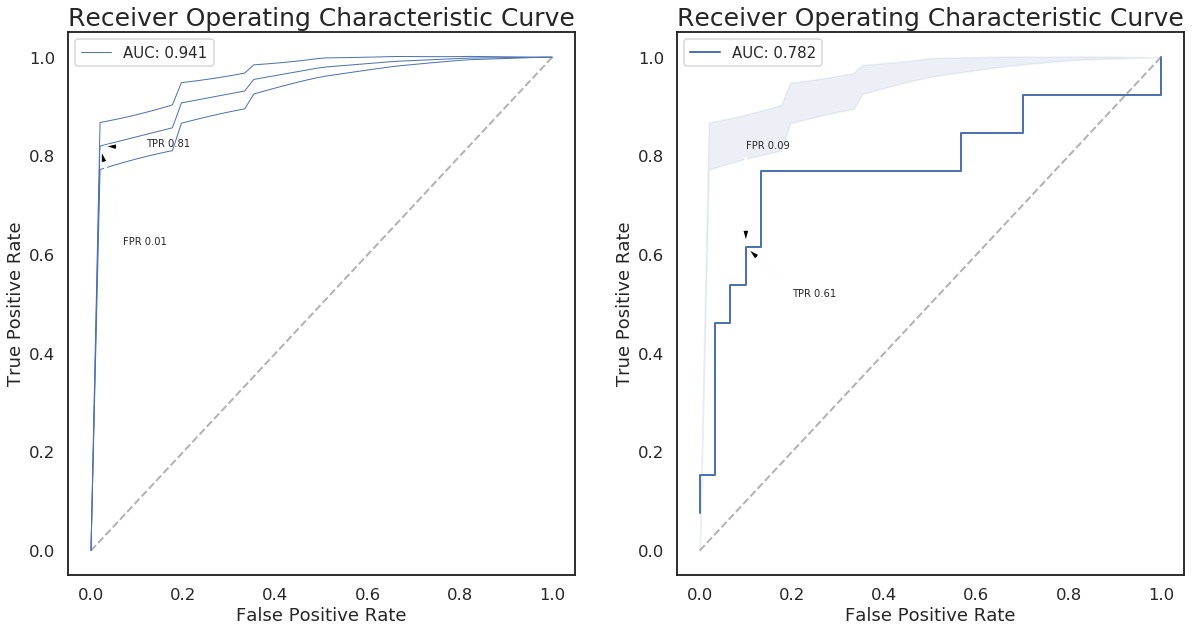

In [40]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
plot_shuffle(ax[0],shuffle_split_roc_file+'/evaluation.stratified_shuffle_split.h5')
plot_jack(ax[1],jack_roc_file+'/evaluation.leave_one_out.h5')

## Cluster map

In [41]:
select_feature_file = ''
features = np.array(original_mx.index[1000:1030]) #np.loadtxt(select_feature_file,dtype='str')
class_compare = np.array(['Colorectal Cancer', 'Healthy Control'])  # put health/normal last

In [42]:
def scale(axis,table):
    '''
    axis: 0(by sample)/1(by feature)/2(both 0 and 1)
    '''
    scaler = StandardScaler()
    arr = np.array(table)
    if axis==0:
        return scaler.fit_transform(arr)
    elif axis==1:
        return scaler.fit_transform(arr.T).T
    elif axis==2:
        return scaler.fit_transform(scaler.fit_transform(arr).T).T
def clustermap(origin_matrix,featurename,sample_class, class_compare):
    samples_use = np.array(sample_class.index)[np.isin(sample_class.label,class_compare)]
    sample_class_use = sample_class.iloc[np.isin(sample_class.label,class_compare)]
    cpm_table = original_mx/original_mx.sum(axis=0)*10e6
    cpm_table_use = cpm_table.loc[featurename,samples_use]
    cpm_matrix= np.ma.log2(np.array(cpm_table_use))
    cpm_table_use.iloc[:,:] = RobustScaler().fit_transform(cpm_matrix.T).T
    rgblabel = np.repeat('r',samples_use.shape[0])
    rgblabel[np.where(sample_class_use.label==class_compare[-1])] = 'b'
    sns.clustermap(cpm_table_use,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    return cpm_table_use

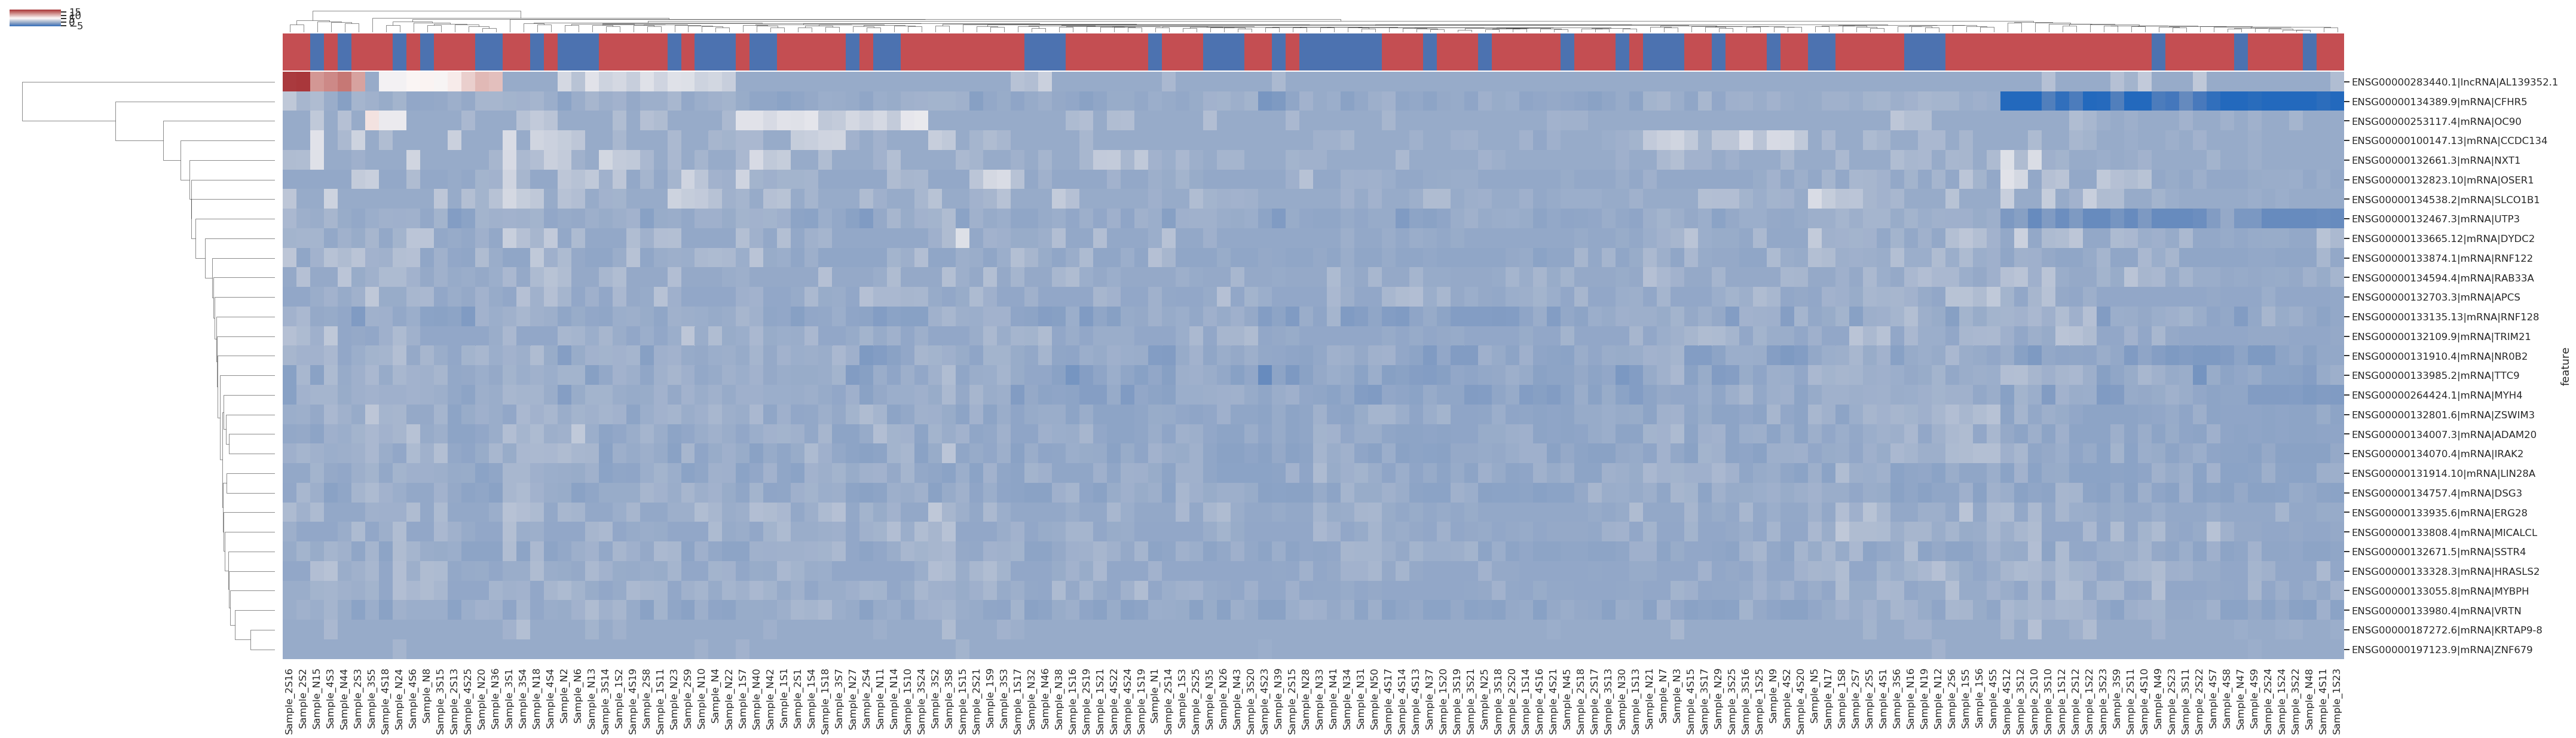

In [43]:
cpm_table_use =  clustermap(original_mx,features,sample_class,class_compare)

In [158]:
sampleclasstmp = sample_class.T.loc[:,cpm_table_use.columns]
sampleclasstmp  = sampleclasstmp.reset_index(drop=True)
batchtabletmp = batchtable.T.loc[:,cpm_table_use.columns]
batchtabletmp =   batchtabletmp.reset_index(drop=True)
cpm_table_use_label_batch = pd.concat((sampleclasstmp,batchtabletmp,cpm_table_use))
cpm_table_use_label_batch['genetype'] = ''
cpm_table_use_label_batch = pd.concat((cpm_table_use_label_batch.iloc[:,-1],cpm_table_use_label_batch.iloc[:,:-1]),axis=1)
cpm_table_use_label_batch.to_csv('test.txt',sep='\t')
cpm_table_use_label_batch = pd.read_table('test.txt',sep='\t',index_col=0)
test = pd.read_table('rc_two_cats.txt',index_col=0)

In [44]:
%pylab inline
from clustergrammer_widget import Network, clustergrammer_widget
import pandas as pd
net = Network(clustergrammer_widget)

df = pd.DataFrame(np.random.normal(size=(30, 30)))
df.index = np.asarray(['R%d'%i for i in range(df.shape[0])])
df.columns = np.asarray(['C%d'%i for i in range(df.shape[1])])
# load matrix file
net.load_df(cpm_table_use)

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

Populating the interactive namespace from numpy and matplotlib


clustergrammer_widget(network='{"row_nodes": [{"name": "ENSG00000187272.6|mRNA|KRTAP9-8", "ini": 30, "clust": 28, "rank": 14, "rankvar": 1, "group": [28.0, 28.0, 27.0, 27.0, 25.0, 19.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000131910.4|mRNA|NR0B2", "ini": 29, "clust": 8, "rank": 4, "rankvar": 18, "group": [9.0, 9.0, 8.0, 8.0, 7.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000131914.10|mRNA|LIN28A", "ini": 28, "clust": 6, "rank": 8, "rankvar": 2, "group": [11.0, 11.0, 10.0, 10.0, 9.0, 7.0, 3.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132109.9|mRNA|TRIM21", "ini": 27, "clust": 19, "rank": 19, "rankvar": 13, "group": [21.0, 21.0, 20.0, 20.0, 19.0, 14.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000253117.4|mRNA|OC90", "ini": 26, "clust": 12, "rank": 28, "rankvar": 27, "group": [14.0, 14.0, 13.0, 13.0, 12.0, 9.0, 4.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132467.3|mRNA|UTP3", "ini": 25, "clust": 9, "rank": 1, "rankvar": 24, "group": [7.0, 7.0, 7.0, 7.0, 7.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132661.3|mRNA|NXT1", "ini": 24, "clust": 24, "rank": 25, "rankvar": 23, "group": [22.0, 22.0, 21.0, 21.0, 20.0, 15.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132671.5|mRNA|SSTR4", "ini": 23, "clust": 26, "rank": 13, "rankvar": 6, "group": [26.0, 26.0, 25.0, 25.0, 23.0, 17.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132703.3|mRNA|APCS", "ini": 22, "clust": 13, "rank": 20, "rankvar": 16, "group": [12.0, 12.0, 11.0, 11.0, 10.0, 8.0, 4.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132801.6|mRNA|ZSWIM3", "ini": 21, "clust": 14, "rank": 12, "rankvar": 8, "group": [13.0, 13.0, 12.0, 12.0, 11.0, 8.0, 4.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000132823.10|mRNA|OSER1", "ini": 20, "clust": 20, "rank": 24, "rankvar": 25, "group": [19.0, 19.0, 18.0, 18.0, 17.0, 13.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000283440.1|lncRNA|AL139352.1", "ini": 19, "clust": 15, "rank": 29, "rankvar": 29, "group": [15.0, 15.0, 14.0, 14.0, 13.0, 10.0, 5.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000264424.1|mRNA|MYH4", "ini": 18, "clust": 4, "rank": 2, "rankvar": 12, "group": [3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133055.8|mRNA|MYBPH", "ini": 17, "clust": 17, "rank": 16, "rankvar": 3, "group": [17.0, 17.0, 16.0, 16.0, 15.0, 11.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133135.13|mRNA|RNF128", "ini": 16, "clust": 2, "rank": 3, "rankvar": 17, "group": [6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133328.3|mRNA|HRASLS2", "ini": 15, "clust": 27, "rank": 18, "rankvar": 7, "group": [27.0, 27.0, 26.0, 26.0, 24.0, 18.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000197123.9|mRNA|ZNF679", "ini": 14, "clust": 11, "rank": 9, "rankvar": 0, "group": [30.0, 30.0, 29.0, 29.0, 27.0, 21.0, 7.0, 3.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000100147.13|mRNA|CCDC134", "ini": 13, "clust": 23, "rank": 27, "rankvar": 26, "group": [24.0, 24.0, 23.0, 23.0, 21.0, 15.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133665.12|mRNA|DYDC2", "ini": 12, "clust": 18, "rank": 23, "rankvar": 21, "group": [18.0, 18.0, 17.0, 17.0, 16.0, 12.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133808.4|mRNA|MICALCL", "ini": 11, "clust": 29, "rank": 17, "rankvar": 9, "group": [29.0, 29.0, 28.0, 28.0, 26.0, 20.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133874.1|mRNA|RNF122", "ini": 10, "clust": 16, "rank": 15, "rankvar": 20, "group": [16.0, 16.0, 15.0, 15.0, 14.0, 10.0, 5.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133935.6|mRNA|ERG28", "ini": 9, "clust": 25, "rank": 21, "rankvar": 11, "group": [23.0, 23.0, 22.0, 22.0, 20.0, 15.0, 6.0, 2.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133980.4|mRNA|VRTN", "ini": 8, "clust": 3, "rank": 7, "rankvar": 5, "group": [5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000133985.2|mRNA|TTC9", "ini": 7, "clust": 5, "rank": 6, "rankvar": 19, "group": [4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "ENSG00000134007.3|mRNA|ADAM20", 

In [45]:
net.load_file('rc_two_cats.txt')

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

clustergrammer_widget(network='{"row_nodes": [{"name": "Gene: CDK4", "ini": 38, "clust": 14, "rank": 30, "rankvar": 20, "cat-0": "Gene Type: Interesting", "cat_0_index": 0, "group": [10.0, 9.0, 8.0, 5.0, 5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: LMTK3", "ini": 37, "clust": 20, "rank": 28, "rankvar": 24, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 17, "group": [21.0, 20.0, 19.0, 13.0, 11.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: LRRK2", "ini": 36, "clust": 26, "rank": 9, "rankvar": 10, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 18, "group": [26.0, 25.0, 22.0, 16.0, 13.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: UHMK1", "ini": 35, "clust": 25, "rank": 26, "rankvar": 14, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 19, "group": [28.0, 27.0, 24.0, 18.0, 14.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: EGFR", "ini": 34, "clust": 13, "rank": 33, "rankvar": 7, "cat-0": "Gene Type: Interesting", "cat_0_index": 1, "group": [12.0, 11.0, 10.0, 5.0, 5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: STK32A", "ini": 33, "clust": 32, "rank": 36, "rankvar": 32, "cat-0": "Gene Type: Interesting", "cat_0_index": 2, "group": [33.0, 32.0, 29.0, 22.0, 17.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: NRK", "ini": 32, "clust": 15, "rank": 35, "rankvar": 33, "cat-0": "Gene Type: Interesting", "cat_0_index": 3, "group": [11.0, 10.0, 9.0, 5.0, 5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: ERBB2", "ini": 31, "clust": 34, "rank": 24, "rankvar": 9, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 20, "group": [35.0, 34.0, 31.0, 23.0, 18.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: ERBB4", "ini": 30, "clust": 30, "rank": 6, "rankvar": 2, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 21, "group": [31.0, 30.0, 27.0, 20.0, 16.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: AAK1", "ini": 29, "clust": 36, "rank": 18, "rankvar": 8, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 22, "group": [37.0, 36.0, 33.0, 25.0, 19.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: SRPK3", "ini": 28, "clust": 4, "rank": 8, "rankvar": 15, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 23, "group": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: STK39", "ini": 27, "clust": 35, "rank": 7, "rankvar": 4, "cat-0": "Gene Type: Interesting", "cat_0_index": 4, "group": [36.0, 35.0, 32.0, 24.0, 18.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: GRK4", "ini": 26, "clust": 3, "rank": 1, "rankvar": 3, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 24, "group": [3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: TBK1", "ini": 25, "clust": 12, "rank": 34, "rankvar": 26, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 25, "group": [13.0, 12.0, 11.0, 6.0, 5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: INSRR", "ini": 24, "clust": 23, "rank": 13, "rankvar": 5, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 26, "group": [23.0, 22.0, 20.0, 14.0, 12.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: IRAK1", "ini": 23, "clust": 11, "rank": 20, "rankvar": 30, "cat-0": "Gene Type: Interesting", "cat_0_index": 5, "group": [14.0, 13.0, 12.0, 7.0, 6.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: KDR", "ini": 22, "clust": 33, "rank": 19, "rankvar": 11, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 27, "group": [34.0, 33.0, 30.0, 22.0, 17.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: NPR1", "ini": 21, "clust": 16, "rank": 27, "rankvar": 29, "cat-0": "Gene Type: Interesting", "cat_0_index": 6, "group": [20.0, 19.0, 18.0, 12.0, 10.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: PAK3", "ini": 20, "clust": 9, "rank": 11, "rankvar": 12, "cat-0": "Gene Type: Not Interesting", "cat_0_index": 28, "group": [16.0, 15.0, 14.0, 9.0, 8.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, {"name": "Gene: PDGFRA", "ini": 19, "clust": 7, "rank": 2, "rankvar": 0, "cat-0": "Gene Type: Interesting", "cat_0_index": 7, "group": [7.0, 6.0

## bar plot of feature importance

In [83]:
feature_weight_path = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/transcripts_exrna/Normal-HCC/random_forest.10.robust.leave_one_out/feature_importances.txt'


In [86]:
def feature_weight_bar(feature_weight_path):
    feature_weight_table = pd.read_table(feature_weight_path,index_col=0,names=['gene','weight'])
    featurename = np.array(feature_weight_table.index)
    feature_weight = np.array(feature_weight_table.weight)
    featurename = np.array([featurename[i].split('|')[-2] for i in range(featurename.shape[0]) ])
    featurename = featurename[np.argsort(-feature_weight)]
    feature_weight = -np.sort(-feature_weight)
    dataframe= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),feature_weight.reshape(-1,1)),axis=1),columns=['name','weight'])
    dataframe.weight  =  pd.to_numeric(dataframe.weight)
    fig,ax=plt.subplots(1,figsize=(30,6))
    sns.barplot(data=dataframe,x='name',y='weight',palette="Blues_d",saturation=.5)

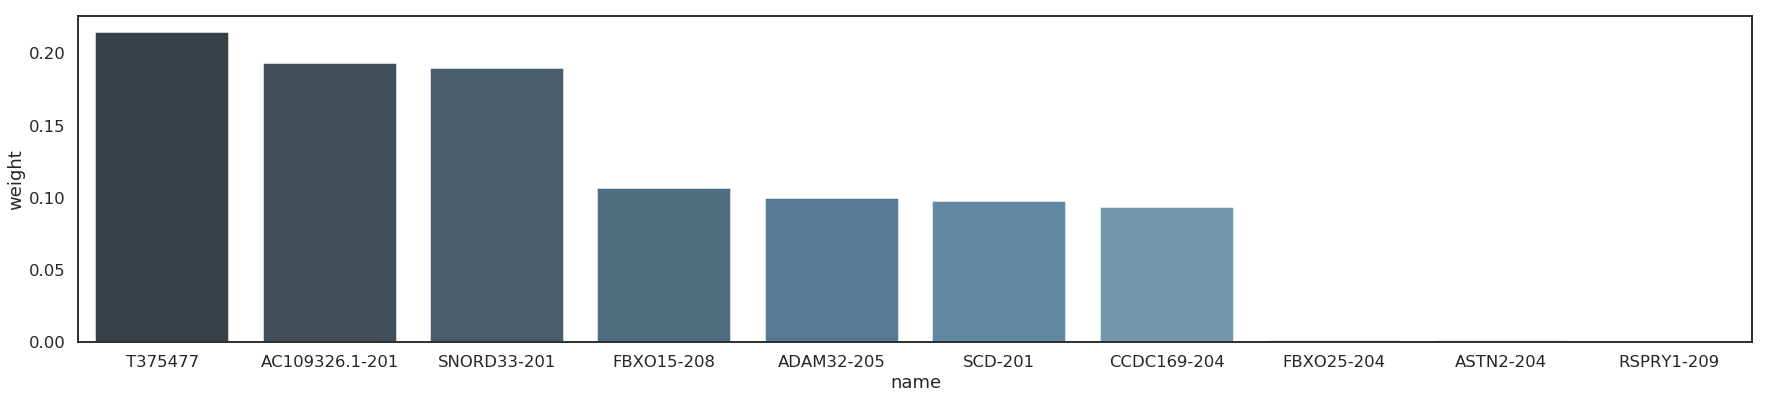

In [87]:
feature_weight_bar(feature_weight_path)

## sampling

## Venn plot

## AUC line plot